# Relationship between purchases and personal attributes

Inferring demographics
- Start with binary Classification (e.g. race=black; etc)
- Preliminary analysis: 
    - Look at differences in top categories and items
- Create feature vectors for each respondent:
    - Feature per item (product code or title)
    - Include items from top products for each category
    - Use item purchase quantity / all purchase quantity 
    - Proprocess and scale feature vectors
        - E.g. https://scikit-learn.org/stable/modules/preprocessing.html
- Initial modeling with:
    - Logistic regression to be interpretable
    - SVM or Simple multilayer perceptron models
    - SVD as part of a pipeline before logistic regression or SVM model


In [1]:
import datetime
import os

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
fpath = '../data/amazon-data-phase-1-joined-dan-02-2023.csv'
data_df = pd.read_csv(fpath, parse_dates=['Order Date']).rename(columns={'Unnamed: 0': 'ResponseId'})

/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
print('%s rows or raw data' % len(data_df))
print('columns:')
print(data_df.columns)
data_df.head(3)

1014792 rows or raw data
columns:
Index(['ResponseId', 'Order Date', 'Purchase Price Per Unit', 'Quantity',
       'Shipping Address State', 'Title', 'ASIN/ISBN (Product Code)',
       'Category', 'q-demos-age', 'Q-demos-hispanic', 'Q-demos-race',
       'Q-demos-education', 'Q-demos-income', 'Q-demos-gender',
       'Q-sexual-orientation', 'Q-demos-state', 'Q-amazon-use-howmany',
       'Q-amazon-use-hh-size', 'Q-amazon-use-how-oft', 'Q-substance-use_1',
       'Q-substance-use_2', 'Q-substance-use_3', 'Q-personal_1',
       'Q-personal_2', 'Q-life-changes'],
      dtype='object')


,ResponseId,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,q-demos-age,Q-demos-hispanic,...,Q-demos-state,Q-amazon-use-howmany,Q-amazon-use-hh-size,Q-amazon-use-how-oft,Q-substance-use_1,Q-substance-use_2,Q-substance-use_3,Q-personal_1,Q-personal_2,Q-life-changes
0,R_01vNIayewjIIKMF,2018-12-04,$7.98,1,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,FLASH_MEMORY,35 - 44 years,Yes,...,New Jersey,1 (just me!),1 (just me!),Less than 5 times per month,No,No,No,No,No,NaN
1,R_01vNIayewjIIKMF,2018-12-22,$13.99,1,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,HEADPHONES,35 - 44 years,Yes,...,New Jersey,1 (just me!),1 (just me!),Less than 5 times per month,No,No,No,No,No,NaN
2,R_01vNIayewjIIKMF,2018-12-24,$8.99,1,NJ,NaN,B078JZTFN3,NaN,35 - 44 years,Yes,...,New Jersey,1 (just me!),1 (just me!),Less than 5 times per month,No,No,No,No,No,NaN


## Preprocessing

- data restricted to files where data begin in 2018 and end in 2022
- data restricted to range 1-1-2018 (specified in study) to 10-1-2022 (when we started collecting data)
- dropped any rows with null or non-positive price or quantity
- prices mapped to floats
- state names mapped to consistent set (data contains state names both spelled out and abbreviated, with differing casing)
- dates mapped to yyyy-mm

Preprocessing helpers

In [4]:
states_df = pd.read_csv('../data/census/state-abbreviations.csv')
states_df['index'] = states_df['state'].apply(lambda s: s.upper())
states_df = states_df.set_index('index')
state_codes = states_df['code'].to_list()
state_names_map = states_df['code'].to_dict()

print('states df contains %s states'%len(states_df))

def state_code(s):
    if not isinstance(s, str): # probably nan (flat)
        return np.nan
    s = s.upper()
    if s in state_codes:
        return s
    if s in state_names_map:
        return state_names_map[s]
    return np.nan

states_df.head(3)

states df contains 52 states


,state,abbrev,code
index,,,
ALABAMA,Alabama,Ala.,AL
ALASKA,Alaska,Alaska,AK
ARIZONA,Arizona,Ariz.,AZ


In [5]:
def get_unit_price_float(unit_price):
    try:
        return float(unit_price.strip('$').replace(',',''))
    except Exception as e:
        #print('Exception:', e, 'for:', unit_price)
        return 0

In [6]:
# TODO: consider only using data for responseIds with purchses that begin in 2018 and end in 2022
df = data_df.copy()
# Drop rows outside of range 1-1-2018 to 10-1-2023
df = df[
    (df['Order Date'] >= pd.Timestamp('2018-01-01')) \
    & (df['Order Date'] < pd.Timestamp('2022-10-01'))
]
# Drop rows where there is null or non-positive price or quantity
# First handle weird values (found Quantities with '$')
df['Quantity'] = df['Quantity'].astype(str).apply(lambda s: int(s) if s.isnumeric() else np.nan)
df = df[(df.notna()['Purchase Price Per Unit'] | df.notna()['Quantity'])]
# extract unit price and total price as floats
df['unit price'] = df['Purchase Price Per Unit'].apply(get_unit_price_float)
df['total price'] = df['unit price'] * df['Quantity']
df = df[df['total price'] > 0]
df['yyyy-mm'] = df['Order Date'].apply(lambda d: datetime.date.strftime(d, '%Y-%m'))
# use a consisent set of state names
df['shipping state'] = df['Shipping Address State'].apply(state_code)
data_df = df

In [7]:
print('%s cleaned rows' % len(data_df))
data_df.head()

922812 cleaned rows


,ResponseId,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,q-demos-age,Q-demos-hispanic,...,Q-substance-use_1,Q-substance-use_2,Q-substance-use_3,Q-personal_1,Q-personal_2,Q-life-changes,unit price,total price,yyyy-mm,shipping state
0,R_01vNIayewjIIKMF,2018-12-04,$7.98,1.0,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,FLASH_MEMORY,35 - 44 years,Yes,...,No,No,No,No,No,NaN,7.98,7.98,2018-12,NJ
1,R_01vNIayewjIIKMF,2018-12-22,$13.99,1.0,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,HEADPHONES,35 - 44 years,Yes,...,No,No,No,No,No,NaN,13.99,13.99,2018-12,NJ
2,R_01vNIayewjIIKMF,2018-12-24,$8.99,1.0,NJ,NaN,B078JZTFN3,NaN,35 - 44 years,Yes,...,No,No,No,No,No,NaN,8.99,8.99,2018-12,NJ
3,R_01vNIayewjIIKMF,2018-12-25,$10.45,1.0,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,DISHWARE_BOWL,35 - 44 years,Yes,...,No,No,No,No,No,NaN,10.45,10.45,2018-12,NJ
4,R_01vNIayewjIIKMF,2018-12-25,$10.00,1.0,NJ,Proraso Shaving Cream for Men,B00837ZOI0,SHAVING_AGENT,35 - 44 years,Yes,...,No,No,No,No,No,NaN,10.00,10.00,2018-12,NJ


### Hispanic

No     2352
Yes     287
Name: Q-demos-hispanic, dtype: int64


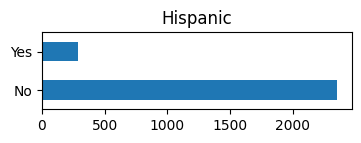

In [8]:
print(data_df.drop_duplicates('ResponseId')['Q-demos-hispanic'].value_counts())
fig,ax = plt.subplots(1,1,figsize=(4,1))
ax.set_title('Hispanic')
_ = data_df.drop_duplicates('ResponseId')['Q-demos-hispanic'].value_counts().plot.barh(ax=ax)

In [9]:
# add boolean to make this data easier to work with
data_df['Hispanic'] = data_df['Q-demos-hispanic'].apply(lambda h: 1 if h=='Yes' else 0)
print('%0.3f = %s/%s respondents reported as Hispanic' % (
    data_df.drop_duplicates('ResponseId')['hispanic'].sum()/len(data_df.drop_duplicates('ResponseId')),
    data_df.drop_duplicates('ResponseId')['hispanic'].sum(), 
    len(data_df.drop_duplicates('ResponseId'))))

KeyError: 'hispanic'

### Race

In [10]:
# What are the unique race values in the data?
# And what is their distribution? 
data_df.drop_duplicates('ResponseId')['Q-demos-race'].value_counts()

White or Caucasian                                                                               2066
Black or African American                                                                         182
Asian                                                                                             180
Other                                                                                              52
White or Caucasian,Asian                                                                           42
White or Caucasian,American Indian/Native American or Alaska Native                                31
White or Caucasian,Black or African American                                                       30
American Indian/Native American or Alaska Native                                                   18
White or Caucasian,Other                                                                            8
White or Caucasian,Black or African American,American Indian/Native American or Al

In [11]:
# Add boolean indicating whether black is included in race answer
data_df['Black'] = data_df['Q-demos-race'].apply(lambda race: 'Black' in str(race))
# What fraction of the respondents are black?
print('%s Black ResponseIds (dropped duplicates)' % data_df.drop_duplicates('ResponseId')['Black'].sum())
print('%s = portion of Black ResponseIds (dropped duplicates)'% (
    round(data_df.drop_duplicates('ResponseId')['Black'].sum()/len(data_df.drop_duplicates('ResponseId')), 4)))
data_df[list(data_df.columns[:6])+['Q-demos-race', 'Black']].head(3)

234 Black ResponseIds (dropped duplicates)
0.0882 = portion of Black ResponseIds (dropped duplicates)


,ResponseId,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,Q-demos-race,Black
0,R_01vNIayewjIIKMF,2018-12-04,$7.98,1.0,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,Black or African American,True
1,R_01vNIayewjIIKMF,2018-12-22,$13.99,1.0,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,Black or African American,True
2,R_01vNIayewjIIKMF,2018-12-24,$8.99,1.0,NJ,NaN,Black or African American,True


In [12]:
# Add boolean indicating whether black is included in race answer
data_df['Asian'] = data_df['Q-demos-race'].apply(lambda race: 'Asian' in str(race))
# What fraction of the respondents are black?
print('%s Asian ResponseIds (dropped duplicates)' % data_df.drop_duplicates('ResponseId')['Asian'].sum())
print('%s = portion of Asian ResponseIds (dropped duplicates)'% (
    round(data_df.drop_duplicates('ResponseId')['Asian'].sum()/len(data_df.drop_duplicates('ResponseId')), 4)))
data_df[list(data_df.columns[:6])+['Q-demos-race', 'Asian', 'Black']].head(3)

234 Asian ResponseIds (dropped duplicates)
0.0882 = portion of Asian ResponseIds (dropped duplicates)


,ResponseId,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,Q-demos-race,Asian,Black
0,R_01vNIayewjIIKMF,2018-12-04,$7.98,1.0,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,Black or African American,False,True
1,R_01vNIayewjIIKMF,2018-12-22,$13.99,1.0,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,Black or African American,False,True
2,R_01vNIayewjIIKMF,2018-12-24,$8.99,1.0,NJ,NaN,Black or African American,False,True


### Sexuality

- Q-sexual-orientation

In [14]:
data_df.drop_duplicates('ResponseId')['Q-sexual-orientation'].value_counts()

heterosexual (straight)    2012
LGBTQ+                      595
prefer not to say            32
Name: Q-sexual-orientation, dtype: int64

## Understanding the data

- What is the distribution of number of unique orders per person? How does this differ by demographic group?
- Distribution of number of unique categories per person?
- Distribution of number of unique products per person?

In [15]:
def plot_unique_orders_hist(df, ax=None, cat='All', bins=20, legend=True):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,2))
        _ = ax.set_xlabel('number of order dates')
        _ = ax.set_title('Histogram of number of order dates: %s' % cat) 
    counts = df.groupby('ResponseId')['Order Date'].nunique() 
    _ = ax.hist(counts, bins=bins, label=cat,density=True)
    if legend:
        ax.legend()

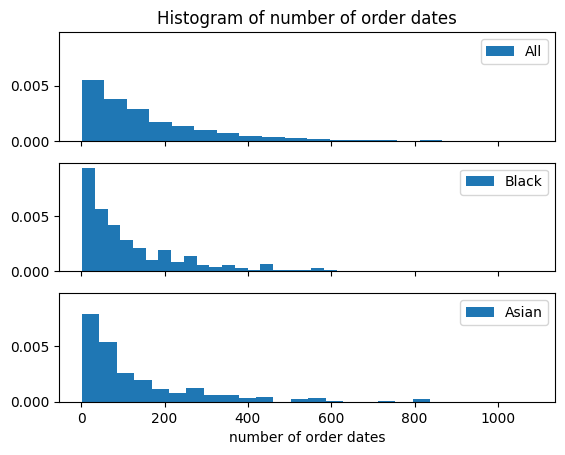

In [16]:
fig, axes = plt.subplots(3,1, sharex=True,sharey=True)
axes[2].set_xlabel('number of order dates')
axes[0].set_title('Histogram of number of order dates')
plot_unique_orders_hist(data_df, ax=axes[0])
plot_unique_orders_hist(data_df[data_df['Black']==True], cat='Black', ax=axes[1])
plot_unique_orders_hist(data_df[data_df['Asian']==True], cat='Asian', ax=axes[2])

In [17]:
def plot_unique_products_hist(df, ax=None, cat='All', bins=20, legend=True):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,2))
        _ = ax.set_xlabel('number of unique products')
        _ = ax.set_title('Histogram of number of unique products ordered: %s' % cat)
    counts = df.groupby('ResponseId')['ASIN/ISBN (Product Code)'].nunique()
    _ = ax.hist(counts, bins=bins, label=cat, density=True)
    if legend:
        ax.legend()

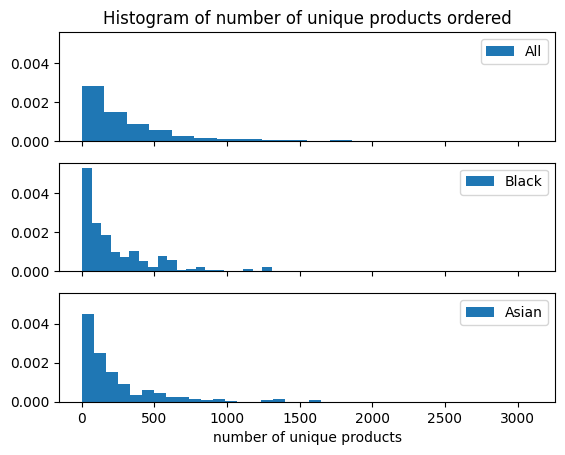

In [18]:
fig, axes = plt.subplots(3,1, sharex=True,sharey=True)
axes[2].set_xlabel('number of unique products')
axes[0].set_title('Histogram of number of unique products ordered')
plot_unique_products_hist(data_df, ax=axes[0])
plot_unique_products_hist(data_df[data_df['Black']==True], cat='Black', ax=axes[1])
plot_unique_products_hist(data_df[data_df['Asian']==True], cat='Asian', ax=axes[2])

In [19]:
def plot_unique_categories_hist(df, ax=None, cat='All', bins=20, legend=True):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,2))
        _ = ax.set_xlabel('number of unique categories')
        _ = ax.set_title('Histogram of number of unique categories ordered: %s' % cat)
    counts = df.groupby('ResponseId')['Category'].nunique()
    _ = ax.hist(counts, bins=bins, label=cat, density=True)
    if legend:
        ax.legend()

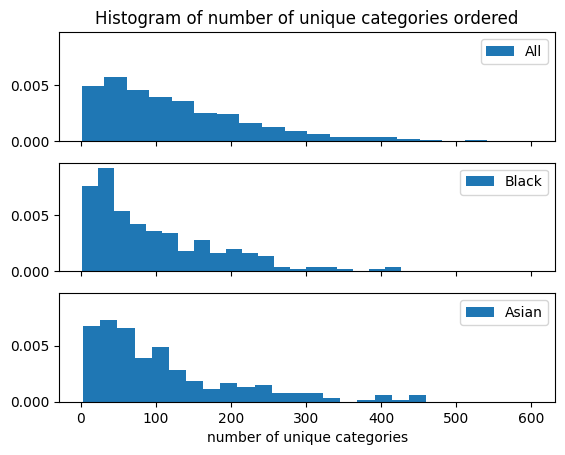

In [20]:
fig, axes = plt.subplots(3,1, sharex=True, sharey=True)
axes[2].set_xlabel('number of unique categories')
axes[0].set_title('Histogram of number of unique categories ordered')
plot_unique_categories_hist(data_df, ax=axes[0])
plot_unique_categories_hist(data_df[data_df['Black']==True], cat='Black', ax=axes[1])
plot_unique_categories_hist(data_df[data_df['Asian']==True], cat='Asian', ax=axes[2])

### Personal 
- Q-personal_1: Have diabetes? 
- Q-personal_2: Use a wheelchair? 
- Answers can be: Y / N / Prefer not to say

In [21]:
# And what is their distribution? 
print('Q-personal_1: Have diabetes?')
print(data_df.drop_duplicates('ResponseId')['Q-personal_1'].value_counts())
# And what is their distribution? 
print('\nQ-personal_2: Use a wheelchair?')
data_df.drop_duplicates('ResponseId')['Q-personal_2'].value_counts()

Q-personal_1: Have diabetes?
No                   2307
Yes                   324
Prefer not to say       8
Name: Q-personal_1, dtype: int64

Q-personal_2: Use a wheelchair?


No                   2585
Yes                    46
Prefer not to say       8
Name: Q-personal_2, dtype: int64

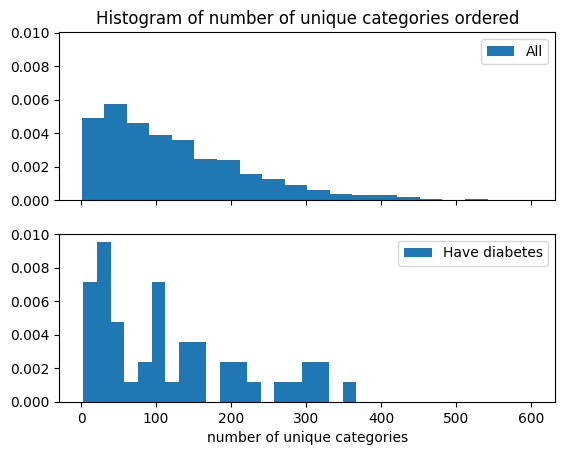

In [22]:
fig, axes = plt.subplots(2,1, sharex=True, sharey=True)
axes[1].set_xlabel('number of unique categories')
axes[0].set_title('Histogram of number of unique categories ordered')
plot_unique_categories_hist(data_df, ax=axes[0])
plot_unique_categories_hist(data_df[data_df['Q-personal_2']=='Yes'], cat='Have diabetes', ax=axes[1])

In general what is the best way to look at the top categories or the top items 
in order to feature engineer?

In [24]:
# how many categories?
categories = data_df['Category'].to_list()
data_df['Category'].nunique()

1806

In [25]:
# top categories
# total top categories in terms of number of purchases
data_df['Category'].value_counts().head(10)

ABIS_BOOK                 44873
PET_FOOD                  20115
GIFT_CARD                 17141
NUTRITIONAL_SUPPLEMENT    13351
SHIRT                     13184
HEALTH_PERSONAL_CARE      10705
ELECTRONIC_CABLE           8937
GROCERY                    8442
MEDICATION                 7866
PANTS                      7802
Name: Category, dtype: int64

In [26]:
orders_threshold = 100
# restrict to categories with at least threshold number of orders
print('restricting categories to those with %s orders' % orders_threshold)
categories = (data_df['Category'].value_counts() > orders_threshold)
categories = categories[categories].index.to_list()
print('%s filtered categories' % len(categories))
# restrict to categories with at least threshold number of orders from different people
ppl_threshold = 30
cats_ppl = data_df.groupby(['Category'])['ResponseId'].nunique().sort_values(ascending=False)
cats_ppl = cats_ppl[(cats_ppl > ppl_threshold)].index.to_list()
print('%s filtered categories when restricting to categories ordered from %s unique people' % (
len(cats_ppl), ppl_threshold))
# categories under both restrictiosn
categories = list(set(categories).intersection(set(cats_ppl)))
print('%s filtered categories applying both filtering methods' % len(categories))

restricting categories to those with 100 orders
934 filtered categories
1284 filtered categories when restricting to categories ordered from 30 unique people
931 filtered categories applying both filtering methods


In [27]:
def get_relative_spend(df, cat):
    """
    Returns relative spend on category as median of ( ($ spend for category / total spend) per person)
    Note: Median is restricted to people who ordered the item at all. Otherwise returns 0s.
    """
    cdf = df[df['Category']==cat]
    cat_spend_by_responseId = cdf.groupby('ResponseId')['total price'].sum()
    total_spend_by_responseId = (df[df['ResponseId'].isin(cdf['ResponseId'].unique())]
                                  .groupby('ResponseId')['total price'].sum())
    return (cat_spend_by_responseId/total_spend_by_responseId).median()

In [28]:
def get_relative_popularity(df, cat):
    """
    Returns relative popularity of category as median of ( (# orders for category / total orders) per person)
    Note: Median is restricted to people who ordered the item at all. Otherwise returns 0s.
    """
    cdf = df[df['Category']==cat]
    cat_orders_by_responseId = cdf.groupby('ResponseId')['Order Date'].count()
    total_orders_by_responseId = (df.groupby('ResponseId')['Order Date'].count())
    return (cat_orders_by_responseId/total_orders_by_responseId).median()

In [29]:
def get_relative_purchasers(df, cat):
    """
    Returns the portion of people who have purchased this item.
    Idea: help us select categories/products to make features vectors with that are not so sparse
    """
    cdf = df[df['Category']==cat]
    return cdf['ResponseId'].nunique()/df['ResponseId'].nunique()

In [30]:
rel_purchasers_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    rel_purchasers_list += [get_relative_purchasers(data_df, cat)]

2023-03-01 09:36:11.739054: 0/931
2023-03-01 09:36:21.447283: 100/931
2023-03-01 09:36:31.344862: 200/931
2023-03-01 09:36:41.145110: 300/931
2023-03-01 09:36:50.641038: 400/931
2023-03-01 09:37:00.438202: 500/931
2023-03-01 09:37:10.400752: 600/931
2023-03-01 09:37:20.253772: 700/931
2023-03-01 09:37:30.082750: 800/931
2023-03-01 09:37:39.723970: 900/931


In [31]:
cat_rel_purchasers = pd.DataFrame({
    'Category': categories,
    'relative purchasers': rel_purchasers_list
}).sort_values('relative purchasers', ascending=False)
cat_rel_purchasers.head(15)

,Category,relative purchasers
798,ABIS_BOOK,0.843514
556,CELLULAR_PHONE_CASE,0.692685
292,ELECTRONIC_CABLE,0.692308
781,HEALTH_PERSONAL_CARE,0.681750
426,SHIRT,0.654977
348,HEADPHONES,0.651584
79,BEAUTY,0.576169
77,CHARGING_ADAPTER,0.560332
753,HOME,0.560332
23,SHOES,0.538084


In [32]:
rel_spend_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    rel_spend_list += [get_relative_spend(data_df, cat)]

2023-03-01 09:37:42.774872: 0/931
2023-03-01 09:37:59.879180: 100/931
2023-03-01 09:38:16.987264: 200/931
2023-03-01 09:38:33.748638: 300/931
2023-03-01 09:38:50.321535: 400/931
2023-03-01 09:39:08.374265: 500/931
2023-03-01 09:39:26.542476: 600/931
2023-03-01 09:39:42.765988: 700/931
2023-03-01 09:40:00.607723: 800/931
2023-03-01 09:40:18.033206: 900/931


In [33]:
cat_rel_spend = pd.DataFrame({
    'Category': categories,
    'relative spend': rel_spend_list
}).sort_values('relative spend', ascending=False)
cat_rel_spend.head(15)

,Category,relative spend
864,NOTEBOOK_COMPUTER,0.059044
203,CELLULAR_PHONE,0.036994
678,TELEVISION,0.032014
824,VIDEO_CARD,0.031543
514,PERSONAL_COMPUTER,0.030507
900,COMPUTER_PROCESSOR,0.028588
798,ABIS_BOOK,0.025710
677,MONITOR,0.023690
786,TABLET_COMPUTER,0.023359
606,MATTRESS,0.022839


In [34]:
rel_popularity_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    rel_popularity_list += [get_relative_popularity(data_df, cat)]

2023-03-01 09:40:23.048446: 0/931
2023-03-01 09:40:34.165007: 100/931
2023-03-01 09:40:45.360685: 200/931
2023-03-01 09:40:56.585780: 300/931
2023-03-01 09:41:07.873602: 400/931
2023-03-01 09:41:19.472393: 500/931
2023-03-01 09:41:31.064893: 600/931
2023-03-01 09:41:41.863419: 700/931
2023-03-01 09:41:52.985406: 800/931
2023-03-01 09:42:04.012392: 900/931


In [35]:
cat_rel_pop = pd.DataFrame({
    'Category': categories,
    'relative orders': rel_popularity_list
}).sort_values('relative orders', ascending=False)
cat_rel_pop.head(15)

,Category,relative orders
798,ABIS_BOOK,0.041852
567,PET_FOOD,0.017241
426,SHIRT,0.014118
15,GIFT_CARD,0.013699
418,NUTRITIONAL_SUPPLEMENT,0.011976
292,ELECTRONIC_CABLE,0.011364
781,HEALTH_PERSONAL_CARE,0.011154
859,PANTS,0.010363
556,CELLULAR_PHONE_CASE,0.010124
387,VEGETABLE,0.009603


In [36]:
# get the same list for people who answered yes to the diabetes Q
diabetes_data_df = data_df[data_df['Q-personal_1']=='Yes']

In [37]:
diabetes_rel_purchasers_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    diabetes_rel_purchasers_list += [get_relative_purchasers(diabetes_data_df, cat)]
diabetes_rel_purchasers = pd.DataFrame({
    'Category': categories,
    'relative purchasers': diabetes_rel_purchasers_list
}).sort_values('relative purchasers', ascending=False)
diabetes_rel_purchasers.head(15)

2023-03-01 09:42:07.810904: 0/931
2023-03-01 09:42:09.275193: 100/931
2023-03-01 09:42:10.645017: 200/931
2023-03-01 09:42:12.018558: 300/931
2023-03-01 09:42:13.408896: 400/931
2023-03-01 09:42:14.781002: 500/931
2023-03-01 09:42:16.168097: 600/931
2023-03-01 09:42:17.545002: 700/931
2023-03-01 09:42:18.929204: 800/931
2023-03-01 09:42:20.293348: 900/931


,Category,relative purchasers
798,ABIS_BOOK,0.833333
292,ELECTRONIC_CABLE,0.734568
781,HEALTH_PERSONAL_CARE,0.725309
348,HEADPHONES,0.685185
556,CELLULAR_PHONE_CASE,0.679012
426,SHIRT,0.648148
77,CHARGING_ADAPTER,0.592593
753,HOME,0.570988
79,BEAUTY,0.570988
127,BATTERY,0.570988


In [38]:
diabetes_rel_spend_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    diabetes_rel_spend_list += [get_relative_spend(diabetes_data_df, cat)]

2023-03-01 09:42:20.733708: 0/931
2023-03-01 09:42:23.201655: 100/931
2023-03-01 09:42:25.609341: 200/931
2023-03-01 09:42:27.933488: 300/931
2023-03-01 09:42:30.289441: 400/931
2023-03-01 09:42:32.807206: 500/931
2023-03-01 09:42:35.355062: 600/931
2023-03-01 09:42:37.654041: 700/931
2023-03-01 09:42:40.171379: 800/931
2023-03-01 09:42:42.611839: 900/931


In [39]:
diabetes_cat_rel_spend = pd.DataFrame({
    'Category': categories,
    'relative spend': diabetes_rel_spend_list
}).sort_values('relative spend', ascending=False)
diabetes_cat_rel_spend.head(15)

,Category,relative spend
864,NOTEBOOK_COMPUTER,0.055053
677,MONITOR,0.035511
481,BABY_FORMULA,0.033049
514,PERSONAL_COMPUTER,0.031388
824,VIDEO_CARD,0.029835
203,CELLULAR_PHONE,0.028804
678,TELEVISION,0.025263
606,MATTRESS,0.024518
798,ABIS_BOOK,0.023752
658,ROBOTIC_VACUUM_CLEANER,0.023547


In [40]:
diabetes_rel_popularity_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    diabetes_rel_popularity_list += [get_relative_popularity(diabetes_data_df, cat)]

2023-03-01 09:42:43.367716: 0/931
2023-03-01 09:42:45.006477: 100/931
2023-03-01 09:42:46.653907: 200/931
2023-03-01 09:42:48.283292: 300/931
2023-03-01 09:42:49.907969: 400/931
2023-03-01 09:42:51.640462: 500/931
2023-03-01 09:42:53.267640: 600/931
2023-03-01 09:42:54.910100: 700/931
2023-03-01 09:42:56.586113: 800/931
2023-03-01 09:42:58.238699: 900/931


In [41]:
diabetes_cat_rel_pop = pd.DataFrame({
    'Category': categories[:len(diabetes_rel_popularity_list)],
    'relative orders': diabetes_rel_popularity_list
}).sort_values('relative orders', ascending=False)
diabetes_cat_rel_pop.head(20)

,Category,relative orders
798,ABIS_BOOK,0.038568
426,SHIRT,0.014101
567,PET_FOOD,0.013378
418,NUTRITIONAL_SUPPLEMENT,0.012909
292,ELECTRONIC_CABLE,0.012579
781,HEALTH_PERSONAL_CARE,0.012121
920,THERMOPLASTIC_FILAMENT,0.011765
15,GIFT_CARD,0.011765
556,CELLULAR_PHONE_CASE,0.010841
638,SKIN_MOISTURIZER,0.009137


In [42]:
# How to select which to use as features?
# 324 ppl with diabetes (Y=1)
# a rule of thumb is to use 15x more parameters than events
print('try ~ %s parameters'%round(320/15))
top_pop_cats = cat_rel_pop

try ~ 21 parameters


In [43]:
# take the top 20 categories that ppl with diabetes have purchased from
diab_tcats = diabetes_rel_purchasers.head(20)['Category'].to_list()
# and then plot their relative popularity

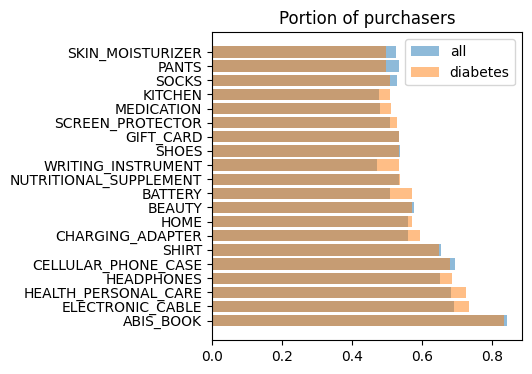

In [44]:
tcats = diab_tcats
fig, ax = plt.subplots(1,1, figsize=(4, 4*len(tcats)/20))
ax.set_title('Portion of purchasers')
ax.barh(tcats, cat_rel_purchasers.set_index('Category').loc[tcats]['relative purchasers'], alpha=0.5, label='all')
ax.barh(tcats, diabetes_rel_purchasers.set_index('Category').loc[tcats]['relative purchasers'], alpha=0.5, label='diabetes')
_ = ax.legend()

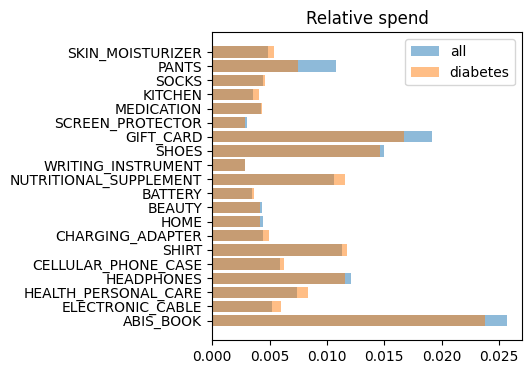

In [45]:
fig, ax = plt.subplots(1,1, figsize=(4, 4*len(tcats)/20))
ax.set_title('Relative spend')
ax.barh(tcats, cat_rel_spend.set_index('Category').loc[tcats]['relative spend'], alpha=0.5, label='all')
ax.barh(tcats, diabetes_cat_rel_spend.set_index('Category').loc[tcats]['relative spend'], alpha=0.5, label='diabetes')
_ = ax.legend()

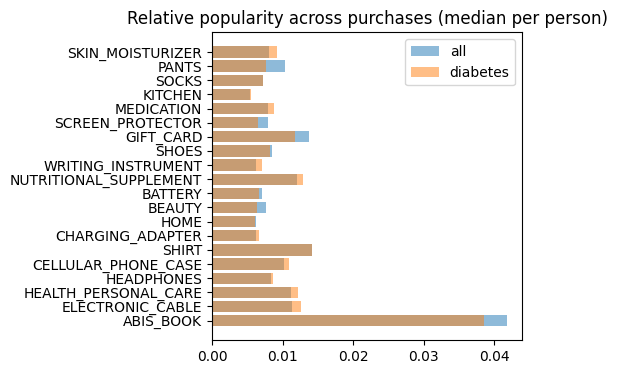

In [46]:
fig, ax = plt.subplots(1,1, figsize=(4, 4*len(tcats)/20))
ax.set_title('Relative popularity across purchases (median per person)')
ax.barh(tcats, cat_rel_pop.set_index('Category').loc[tcats]['relative orders'], alpha=0.5, label='all')
ax.barh(tcats, diabetes_cat_rel_pop.set_index('Category').loc[tcats]['relative orders'], alpha=0.5, label='diabetes')
_ = ax.legend()

### Race comparisons

In [47]:
# get the same list for people who answered yes to the diabetes Q
black_data_df = data_df[data_df['Black']==True]
print('%s Black'%black_data_df['ResponseId'].nunique())
asian_data_df = data_df[data_df['Asian']==True]
print('%s Asian'%asian_data_df['ResponseId'].nunique())

234 Black
234 Asian


In [48]:
black_rel_purchasers_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    black_rel_purchasers_list += [get_relative_purchasers(black_data_df, cat)]
black_rel_purchasers = pd.DataFrame({
    'Category': categories,
    'relative purchasers': black_rel_purchasers_list
}).sort_values('relative purchasers', ascending=False)
black_rel_purchasers.head(15)

2023-03-01 09:44:51.740266: 0/931
2023-03-01 09:44:52.513581: 100/931
2023-03-01 09:44:53.278197: 200/931
2023-03-01 09:44:54.034477: 300/931
2023-03-01 09:44:54.792925: 400/931
2023-03-01 09:44:55.528295: 500/931
2023-03-01 09:44:56.285217: 600/931
2023-03-01 09:44:57.040929: 700/931
2023-03-01 09:44:57.775870: 800/931
2023-03-01 09:44:58.514972: 900/931


,Category,relative purchasers
798,ABIS_BOOK,0.739316
556,CELLULAR_PHONE_CASE,0.649573
292,ELECTRONIC_CABLE,0.623932
348,HEADPHONES,0.615385
781,HEALTH_PERSONAL_CARE,0.576923
426,SHIRT,0.551282
638,SKIN_MOISTURIZER,0.547009
79,BEAUTY,0.525641
23,SHOES,0.495726
15,GIFT_CARD,0.495726


In [49]:
asian_rel_purchasers_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    asian_rel_purchasers_list += [get_relative_purchasers(asian_data_df, cat)]
asian_rel_purchasers = pd.DataFrame({
    'Category': categories,
    'relative purchasers': asian_rel_purchasers_list
}).sort_values('relative purchasers', ascending=False)
asian_rel_purchasers.head(15)

2023-03-01 09:44:58.760387: 0/931
2023-03-01 09:44:59.616462: 100/931
2023-03-01 09:45:00.467849: 200/931
2023-03-01 09:45:01.283885: 300/931
2023-03-01 09:45:02.110760: 400/931
2023-03-01 09:45:02.932294: 500/931
2023-03-01 09:45:03.793345: 600/931
2023-03-01 09:45:04.627108: 700/931
2023-03-01 09:45:05.471216: 800/931
2023-03-01 09:45:06.314234: 900/931


,Category,relative purchasers
798,ABIS_BOOK,0.773504
556,CELLULAR_PHONE_CASE,0.662393
292,ELECTRONIC_CABLE,0.658120
348,HEADPHONES,0.636752
781,HEALTH_PERSONAL_CARE,0.623932
15,GIFT_CARD,0.572650
390,SCREEN_PROTECTOR,0.559829
79,BEAUTY,0.555556
638,SKIN_MOISTURIZER,0.551282
426,SHIRT,0.534188


In [50]:
black_rel_popularity_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    black_rel_popularity_list += [get_relative_popularity(black_data_df, cat)]
black_rel_popularity = pd.DataFrame({
    'Category': categories,
    'relative orders': black_rel_popularity_list
}).sort_values('relative orders', ascending=False)
black_rel_popularity.head(15)

2023-03-01 09:45:06.582834: 0/931
2023-03-01 09:45:07.589785: 100/931


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


2023-03-01 09:45:08.602993: 200/931
2023-03-01 09:45:09.644323: 300/931
2023-03-01 09:45:10.629003: 400/931
2023-03-01 09:45:11.595863: 500/931
2023-03-01 09:45:12.609179: 600/931
2023-03-01 09:45:13.619552: 700/931


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


2023-03-01 09:45:14.636569: 800/931
2023-03-01 09:45:15.614226: 900/931


,Category,relative orders
743,CYCLING_TIRE_TUBE,0.039742
798,ABIS_BOOK,0.032967
417,CRAFT_MOLD,0.026392
306,BLANK_STORAGE_MEDIA,0.024390
747,ADVENT_CALENDAR,0.018088
15,GIFT_CARD,0.017929
387,VEGETABLE,0.017186
564,CAMERA_LENSES,0.016541
426,SHIRT,0.015625
418,NUTRITIONAL_SUPPLEMENT,0.015512


In [51]:
asian_rel_popularity_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    asian_rel_popularity_list += [get_relative_popularity(asian_data_df, cat)]
asian_rel_popularity = pd.DataFrame({
    'Category': categories,
    'relative orders': asian_rel_popularity_list
}).sort_values('relative orders', ascending=False)
asian_rel_popularity.head(15)

2023-03-01 09:45:15.935895: 0/931
2023-03-01 09:45:17.032302: 100/931
2023-03-01 09:45:18.103226: 200/931
2023-03-01 09:45:19.184046: 300/931


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


2023-03-01 09:45:20.244210: 400/931
2023-03-01 09:45:21.284725: 500/931
2023-03-01 09:45:22.340289: 600/931
2023-03-01 09:45:23.384302: 700/931
2023-03-01 09:45:24.467623: 800/931
2023-03-01 09:45:25.591289: 900/931


,Category,relative orders
798,ABIS_BOOK,0.039877
590,BRA_UNDERWEAR_SET,0.021505
567,PET_FOOD,0.019145
15,GIFT_CARD,0.016405
916,ANIMAL_SHELTER,0.015502
292,ELECTRONIC_CABLE,0.014816
418,NUTRITIONAL_SUPPLEMENT,0.012883
781,HEALTH_PERSONAL_CARE,0.012095
556,CELLULAR_PHONE_CASE,0.011364
638,SKIN_MOISTURIZER,0.011323


In [52]:
# Hispanic
hisp_data_df = data_df[data_df['Hispanic']==1]

hisp_rel_popularity_list = []
for i, cat in enumerate(categories):
    if i % 100 == 0:
        print('%s: %s/%s' % (datetime.datetime.now(), i, len(categories)))
    hisp_rel_popularity_list += [get_relative_popularity(hisp_data_df, cat)]
hisp_rel_popularity = pd.DataFrame({
    'Category': categories,
    'relative orders': hisp_rel_popularity_list
}).sort_values('relative orders', ascending=False)
hisp_rel_popularity.head(15)

2023-03-01 09:45:25.995573: 0/931
2023-03-01 09:45:27.180572: 100/931
2023-03-01 09:45:28.402526: 200/931
2023-03-01 09:45:29.752328: 300/931
2023-03-01 09:45:30.987380: 400/931
2023-03-01 09:45:32.179070: 500/931
2023-03-01 09:45:33.373823: 600/931
2023-03-01 09:45:34.564324: 700/931
2023-03-01 09:45:35.767025: 800/931
2023-03-01 09:45:36.984207: 900/931


,Category,relative orders
798,ABIS_BOOK,0.044466
15,GIFT_CARD,0.021277
377,DOWNLOADABLE_VIDEO_GAME,0.015016
292,ELECTRONIC_CABLE,0.014389
426,SHIRT,0.014354
387,VEGETABLE,0.014177
418,NUTRITIONAL_SUPPLEMENT,0.013135
567,PET_FOOD,0.013072
920,THERMOPLASTIC_FILAMENT,0.012539
556,CELLULAR_PHONE_CASE,0.012442


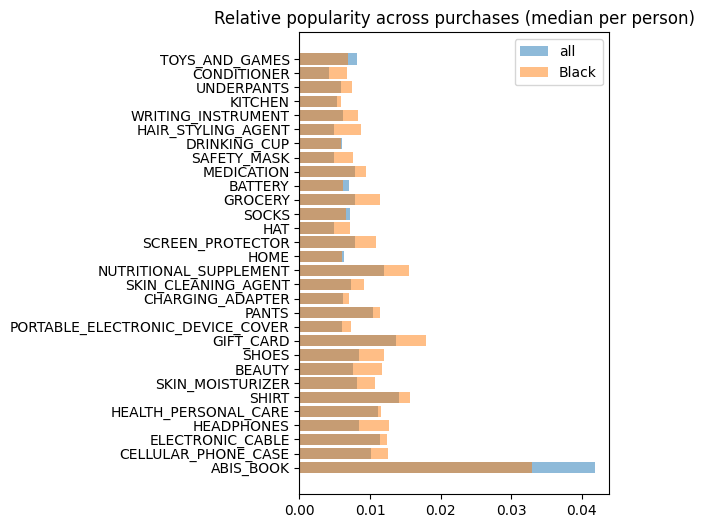

In [53]:
# take the top X categories that ppl in category have purchased from
tcats = black_rel_purchasers.head(30)['Category'].to_list()
# and then plot their relative popularity
# tcats
# see HAIR_STYLING_AGENT
fig, ax = plt.subplots(1,1, figsize=(4, 4*len(tcats)/20))
ax.set_title('Relative popularity across purchases (median per person)')
ax.barh(tcats, cat_rel_pop.set_index('Category').loc[tcats]['relative orders'], alpha=0.5, label='all')
ax.barh(tcats, black_rel_popularity.set_index('Category').loc[tcats]['relative orders'], alpha=0.5, label='Black')
_ = ax.legend()

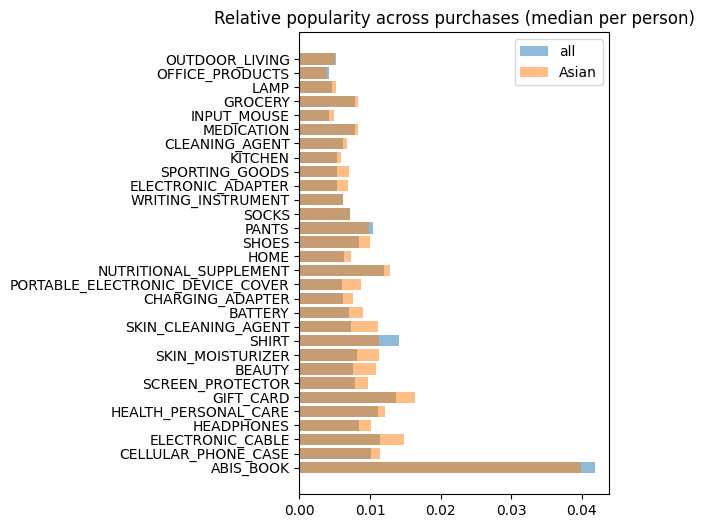

In [54]:
# take the top X categories that ppl in category have purchased from
tcats = asian_rel_purchasers.head(30)['Category'].to_list()
# and then plot their relative popularity
# tcats
fig, ax = plt.subplots(1,1, figsize=(4, 4*len(tcats)/20))
ax.set_title('Relative popularity across purchases (median per person)')
ax.barh(tcats, cat_rel_pop.set_index('Category').loc[tcats]['relative orders'], alpha=0.5, label='all')
ax.barh(tcats, asian_rel_popularity.set_index('Category').loc[tcats]['relative orders'], alpha=0.5, label='Asian')
_ = ax.legend()

For category X (e.g. race=black)

Restrict to categories where at least Y% made a purchase. How many?

Look at differences in relative popularity between category X vs not X, restricted to these categories

In [55]:
# Value counts for number of unique people who bought from the category
tcats_count = 20 # 30 performed worse than 20; i.e. 20 > 30
ppl_threshold_portion = 0.1 # performance: 0.1 > 0.15 > 0.2 > 0.3

In [56]:
print('For Black')
ppl_threshold = round(black_data_df['ResponseId'].nunique() * ppl_threshold_portion)
print('unique purchasers thershold: %s (%s)' % (ppl_threshold, ppl_threshold_portion))

b_cats_ppl = black_data_df.groupby('Category')['ResponseId'].nunique().sort_values(ascending=False)
print('%s unique categories'% len(b_cats_ppl))
b_cats_ppl = b_cats_ppl[b_cats_ppl > ppl_threshold]
print('%s categories above threshold' % len(b_cats_ppl))
b_cats = b_cats_ppl.index
b_cats_ppl.head()

For Black
unique purchasers thershold: 23 (0.1)
1481 unique categories
314 categories above threshold


Category
ABIS_BOOK               173
CELLULAR_PHONE_CASE     152
ELECTRONIC_CABLE        146
HEADPHONES              144
HEALTH_PERSONAL_CARE    135
Name: ResponseId, dtype: int64

In [57]:
b_diff = (
    (abs(black_rel_popularity.set_index('Category')['relative orders'].loc[b_cats] \
      - cat_rel_pop.set_index('Category')['relative orders'].loc[b_cats]) \
     /cat_rel_pop.set_index('Category')['relative orders'].loc[b_cats])
    .rename('difference in rel popularity')
)
b_diff = b_diff.sort_values(ascending=False)
# b_diff.head(20)

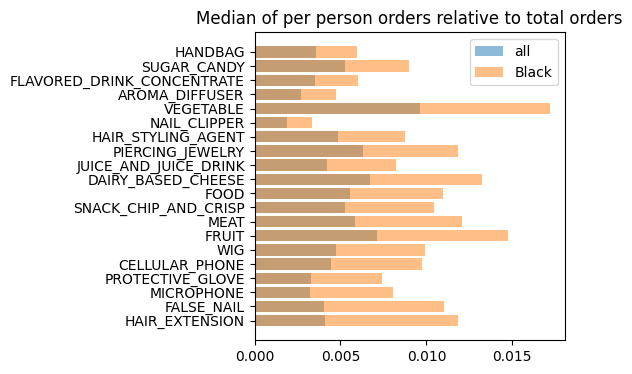

In [58]:
b_tcats = b_diff.head(tcats_count).index.to_list()
fig, ax = plt.subplots(1,1, figsize=(4, 4*tcats_count/20))
ax.set_title('Median of per person orders relative to total orders')
ax.barh(b_tcats, cat_rel_pop.set_index('Category').loc[b_tcats]['relative orders'], alpha=0.5, label='all')
ax.barh(b_tcats, black_rel_popularity.set_index('Category').loc[b_tcats]['relative orders'], alpha=0.5, label='Black')
_ = ax.legend()

In [59]:
print('For Asian')
ppl_threshold = round(asian_data_df['ResponseId'].nunique() * ppl_threshold_portion)
print('unique purchasers thershold: %s (%s)' % (ppl_threshold, ppl_threshold_portion))

a_cats_ppl = asian_data_df.groupby('Category')['ResponseId'].nunique().sort_values(ascending=False)
print('%s unique categories'% len(a_cats_ppl))
a_cats_ppl = a_cats_ppl[a_cats_ppl > ppl_threshold]
print('%s categories above threshold' % len(a_cats_ppl))
a_cats = a_cats_ppl.index
a_cats_ppl.head()

For Asian
unique purchasers thershold: 23 (0.1)
1510 unique categories
358 categories above threshold


Category
ABIS_BOOK               181
CELLULAR_PHONE_CASE     155
ELECTRONIC_CABLE        154
HEADPHONES              149
HEALTH_PERSONAL_CARE    146
Name: ResponseId, dtype: int64

In [60]:
a_diff = (
    (abs(asian_rel_popularity.set_index('Category')['relative orders'].loc[a_cats] \
      - cat_rel_pop.set_index('Category')['relative orders'].loc[a_cats]) \
     /cat_rel_pop.set_index('Category')['relative orders'].loc[a_cats])
    .rename('difference in rel popularity')
)
a_diff = a_diff.sort_values(ascending=False)
a_diff.head()

Category
MONITOR             1.435226
EARRING             1.109559
HEADPHONE_EARPAD    1.083333
TWEEZER             0.943364
DISPLAY_ALBUM       0.847554
Name: difference in rel popularity, dtype: float64

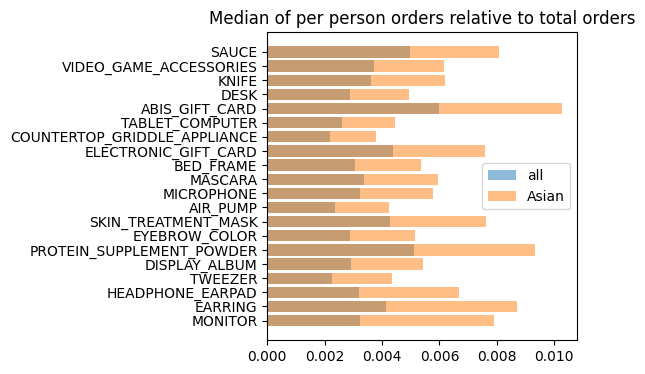

In [61]:
a_tcats = a_diff.head(tcats_count).index.to_list()
fig, ax = plt.subplots(1,1, figsize=(4, 4*tcats_count/20))
ax.set_title('Median of per person orders relative to total orders')
ax.barh(a_tcats, cat_rel_pop.set_index('Category').loc[a_tcats]['relative orders'], alpha=0.5, label='all')
ax.barh(a_tcats, asian_rel_popularity.set_index('Category').loc[a_tcats]['relative orders'], alpha=0.5, label='Asian')
_ = ax.legend()

Do the same for Hispanic

In [62]:
print('For Hispanic')
ppl_threshold = round(hisp_data_df['ResponseId'].nunique() * ppl_threshold_portion)
print('unique purchasers thershold: %s (%s)' % (ppl_threshold, ppl_threshold_portion))

hisp_cats_ppl = hisp_data_df.groupby('Category')['ResponseId'].nunique().sort_values(ascending=False)
print('%s unique categories'% len(a_cats_ppl))
hisp_cats_ppl = hisp_cats_ppl[hisp_cats_ppl > ppl_threshold]
print('%s categories above threshold' % len(hisp_cats_ppl))
hisp_cats = hisp_cats_ppl.index
hisp_cats_ppl.head()

For Hispanic
unique purchasers thershold: 29 (0.1)
358 unique categories
326 categories above threshold


Category
ABIS_BOOK               230
CELLULAR_PHONE_CASE     193
ELECTRONIC_CABLE        192
HEADPHONES              187
HEALTH_PERSONAL_CARE    171
Name: ResponseId, dtype: int64

In [63]:
hisp_diff = (
    (abs(hisp_rel_popularity.set_index('Category')['relative orders'].loc[hisp_cats] \
      - cat_rel_pop.set_index('Category')['relative orders'].loc[hisp_cats]) \
     /cat_rel_pop.set_index('Category')['relative orders'].loc[hisp_cats])
    .rename('difference in rel popularity')
)
hisp_diff = hisp_diff.sort_values(ascending=False)
hisp_diff.head()

Category
EXERCISE_BAND              1.077932
VIDEO_GAME_CONSOLE         0.988736
DOWNLOADABLE_VIDEO_GAME    0.982082
STORAGE_BAG                0.901042
BODY_LUBRICANT             0.847007
Name: difference in rel popularity, dtype: float64

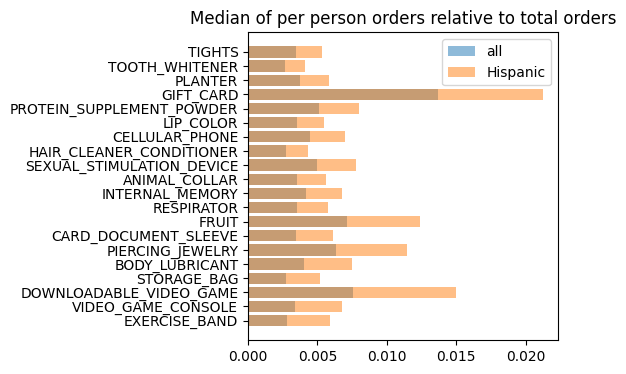

In [64]:
hisp_tcats = hisp_diff.head(tcats_count).index.to_list()
fig, ax = plt.subplots(1,1, figsize=(4, 4*tcats_count/20))
ax.set_title('Median of per person orders relative to total orders')
ax.barh(hisp_tcats, cat_rel_pop.set_index('Category').loc[hisp_tcats]['relative orders'], alpha=0.5, label='all')
ax.barh(hisp_tcats, hisp_rel_popularity.set_index('Category').loc[hisp_tcats]['relative orders'], alpha=0.5, label='Hispanic')
_ = ax.legend()

Do the same for diabetes

In [65]:
print('For diabetes')
ppl_threshold = round(diabetes_data_df['ResponseId'].nunique() * ppl_threshold_portion)
print('unique purchasers thershold: %s (%s)' % (ppl_threshold, ppl_threshold_portion))

d_cats_ppl = diabetes_data_df.groupby('Category')['ResponseId'].nunique().sort_values(ascending=False)
print('%s unique categories'% len(d_cats_ppl))
d_cats_ppl = d_cats_ppl[d_cats_ppl > ppl_threshold]
print('%s categories above threshold' % len(d_cats_ppl))
d_cats = d_cats_ppl.index
d_cats_ppl.head()

For diabetes
unique purchasers thershold: 32 (0.1)
1596 unique categories
406 categories above threshold


Category
ABIS_BOOK               270
ELECTRONIC_CABLE        238
HEALTH_PERSONAL_CARE    235
HEADPHONES              222
CELLULAR_PHONE_CASE     220
Name: ResponseId, dtype: int64

In [66]:
d_diff = (
    (abs(diabetes_cat_rel_pop.set_index('Category')['relative orders'].loc[d_cats] \
      - cat_rel_pop.set_index('Category')['relative orders'].loc[d_cats]) \
     /cat_rel_pop.set_index('Category')['relative orders'].loc[d_cats])
    .rename('difference in rel popularity')
)
d_diff = d_diff.sort_values(ascending=False)
d_diff.head()

Category
YARN                          0.666374
PAPER_TOWEL                   0.483360
PAINT_BRUSH                   0.474090
SECURITY_CAMERA               0.461538
FLAVORED_DRINK_CONCENTRATE    0.454256
Name: difference in rel popularity, dtype: float64

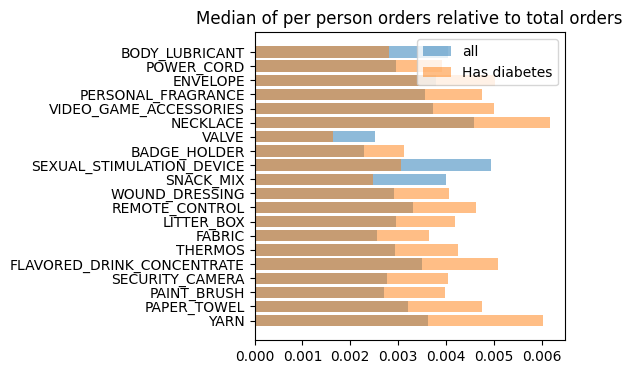

In [67]:
d_tcats = d_diff.head(tcats_count).index.to_list()
fig, ax = plt.subplots(1,1, figsize=(4, 4*tcats_count/20))
ax.set_title('Median of per person orders relative to total orders')
ax.barh(d_tcats, cat_rel_pop.set_index('Category').loc[d_tcats]['relative orders'], alpha=0.5, label='all')
ax.barh(d_tcats, diabetes_cat_rel_pop.set_index('Category').loc[d_tcats]['relative orders'], alpha=0.5, label='Has diabetes')
_ = ax.legend()

Are people with diabetes ordering fewer sex related items? 
And doing more crafts?
And owning more cats?
And drinking more sugary drinks?

What are these things?

In [68]:
data_df[data_df['Category'].isin([
    'BODY_LUBRICANT', 'SEXUAL_STIMULATION_DEVICE', 'VALVE'
])].drop_duplicates('ASIN/ISBN (Product Code)')[data_df.columns[1:8]].head()

data_df[data_df['Category'].isin([
    'VALVE'
])].drop_duplicates('ASIN/ISBN (Product Code)')[data_df.columns[1:8]].head()

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category
4798,2020-07-28,$19.95,1.0,UT,JP's NO-LEAK Metal Bidet T-Adapter with Shut-o...,B082FQV2CM,VALVE
15028,2020-07-22,$7.95,1.0,AR,Kawasaki Bayou 220 Replacement Fuel Petcock Ga...,B07WF9MDK9,VALVE
16189,2021-10-29,$5.99,1.0,MICHIGAN,Genuine Hyundai 26740-32804 PCV Valve,B00BJMEUUO,VALVE
22074,2022-04-27,$10.13,1.0,NE,"Shower Valve, Aomasi Brass Constructed Shut Of...",B0722P16L6,VALVE
22916,2020-03-21,$10.64,1.0,OH,"LASCO 06-9111 Angle Stop Add-A-Tee Valve, 3/8-...",B003B6JC4A,VALVE


## Models

In [69]:
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn import svm

### Make the feature vectors

Assume n categories chosen for features

x_i = [x1, x2, ...,xn] for the n categories chosen

where each element is the relative orders of that item. i.e. number of unique purchases for that item relative to total purchases for person i.

In [70]:
def get_category_one_hot_encodings(df, cat):
    return ((df[df['Category']==cat]
        .groupby(['ResponseId'])['Order Date'].count() > 0)
        .reindex(df['ResponseId'].unique())
        .fillna(0)
        .astype(int))

def get_relative_orders(df, cat):
    """Returns relative orders for category cat for each ResponseId in dataframe df."""
    return (df[df['Category']==cat].groupby(['ResponseId'])['Order Date'].nunique()\
        /df.groupby(['ResponseId'])['Order Date'].nunique()).fillna(0).to_list()

def get_data_one_hot_encording_for_categories(df, cats, Ycol):
    X_dict = {cat: get_category_one_hot_encodings(df, cat) for cat in cats}
    X_dict['ResponseId'] = df['ResponseId'].unique()
    data = pd.DataFrame(X_dict).set_index('ResponseId')
    Y = df.drop_duplicates('ResponseId').set_index('ResponseId')[Ycol].astype(int)
    data[Ycol] = Y
    return data

def get_data_rel_orders_for_categories(df, cats, Ycol):
    X_dict = {cat: get_relative_orders(df, cat) for cat in cats}
    X_dict['ResponseId'] = df['ResponseId'].unique()
    data = pd.DataFrame(X_dict).set_index('ResponseId')
    Y = df.drop_duplicates('ResponseId').set_index('ResponseId')[Ycol].astype(int)
    data[Ycol] = Y
    return data

In [71]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def get_auc_plot_roc(clf, X_test, y_test, ylabel, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(3,3))
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    probs = clf.predict_proba(X_test)
    # keep probabilities for positive outcomes only
    probs = probs[:, 1]
    # calculate auc
    auc = roc_auc_score(y_test, probs)
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    # plot the roc curve for the model
    ax.plot(ns_fpr, ns_tpr, linestyle='--')
    ax.plot(fpr, tpr, marker='.', label='%s; AUC=%.3f'%(ylabel, auc))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend()
    print('ROC AUC=%.3f' % (auc))
    return auc

### Black

In [72]:
# define the dataset
data = get_data_rel_orders_for_categories(data_df, b_tcats, 'Black')
X, y = data.drop('Black',axis=1), data['Black']
print(X.shape, y.shape)
data.head()

(2652, 20) (2652,)


,HAIR_EXTENSION,FALSE_NAIL,MICROPHONE,PROTECTIVE_GLOVE,CELLULAR_PHONE,WIG,FRUIT,MEAT,SNACK_CHIP_AND_CRISP,FOOD,...,JUICE_AND_JUICE_DRINK,PIERCING_JEWELRY,HAIR_STYLING_AGENT,NAIL_CLIPPER,VEGETABLE,AROMA_DIFFUSER,FLAVORED_DRINK_CONCENTRATE,SUGAR_CANDY,HANDBAG,Black
ResponseId,,,,,,,,,,,,,,,,,,,,,
R_01vNIayewjIIKMF,0.000000,0.0,0.000000,0.000000,0.025,0.0,0.000000,0.0125,0.000000,0.012500,...,0.012500,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.012500,1
R_037XK72IZBJyF69,0.000000,0.0,0.000000,0.000000,0.000,0.0,0.052265,0.0000,0.017422,0.038328,...,0.010453,0.0,0.000000,0.0,0.031359,0.0,0.003484,0.003484,0.000000,0
R_038ZU6kfQ5f89fH,0.000000,0.0,0.000000,0.037037,0.000,0.0,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.037037,0
R_06RZP9pS7kONINr,0.000000,0.0,0.007692,0.000000,0.000,0.0,0.000000,0.0000,0.000000,0.007692,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.015385,0.023077,0
R_06d9ULxrBmkwSTn,0.012195,0.0,0.000000,0.000000,0.000,0.0,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.0,0.012195,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('data partitioned into  80-20 train-test split')
print('train size = %s; test size = %s' % (len(X_train), len(X_test)))

print('%s/%s Black in train data\n%s/%s Black in test data' % (y_train.sum(),len(y_train),y_test.sum(),len(y_test)))

data partitioned into  80-20 train-test split
train size = 2121; test size = 531
196/2121 Black in train data
38/531 Black in test data


Mean accuracy: 0.8305
ROC AUC=0.694


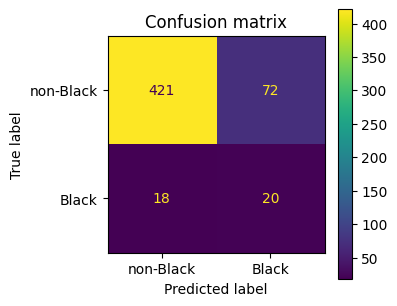

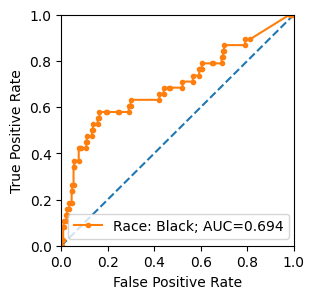

In [74]:
# train
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)
# test
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-Black','Black'])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, 'Race: Black')

Mean accuracy: 0.8625
ROC AUC=0.697


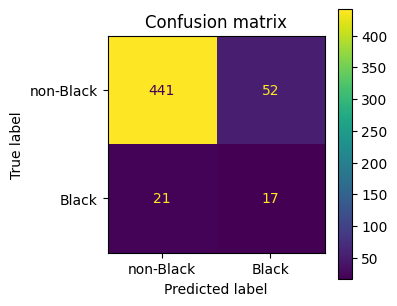

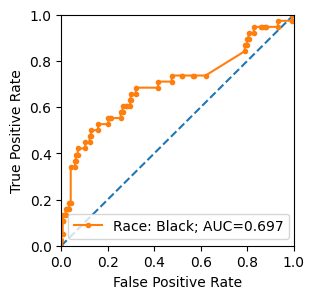

In [76]:
# Try SVM instead
ycol = 'Black'
clf = svm.SVC(kernel='rbf',probability=True, class_weight='balanced') # using radial-like kernal
clf.fit(X_train, y_train)
# test
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-%s'%ycol,ycol])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, 'Race: Black')

### Asian

In [77]:
ycol = 'Asian'
cats = a_tcats
# define the dataset
data = get_data_rel_orders_for_categories(data_df, cats, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('data partitioned into  80-20 train-test split')
print('train size = %s; test size = %s' % (len(X_train), len(X_test)))
print('%s/%s %s in train data\n%s/%s %s in test data' % (y_train.sum(),len(y_train), ycol, y_test.sum(),len(y_test), ycol))

(2652, 20) (2652,)
data partitioned into  80-20 train-test split
train size = 2121; test size = 531
189/2121 Asian in train data
45/531 Asian in test data


Mean accuracy: 0.7872
ROC AUC=0.636


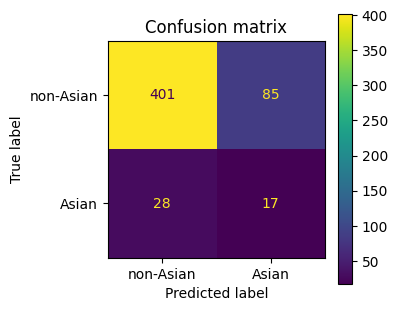

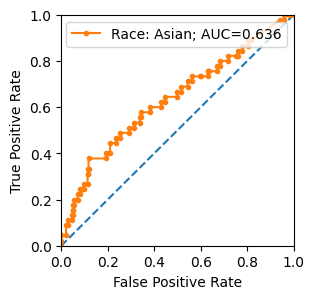

In [78]:
# train
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)
# test
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-%s'%ycol,ycol])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, 'Race: Asian')

Mean accuracy: 0.8249
ROC AUC=0.720


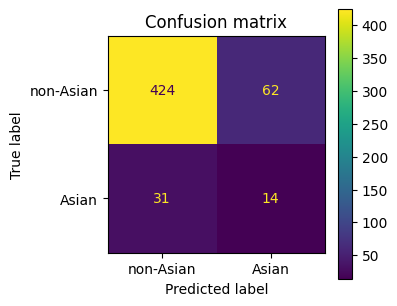

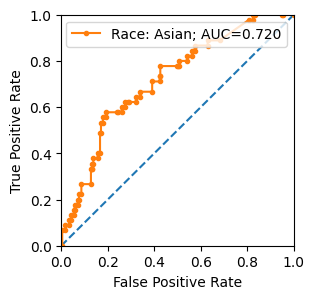

In [79]:
# Try SVM instead
clf = svm.SVC(kernel='rbf',probability=True, class_weight='balanced') # using radial-like kernal
clf.fit(X_train, y_train)
# test
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-%s'%ycol,ycol])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, 'Race: Asian')

### Hispanic

In [80]:
# define the dataset
ycol = 'Hispanic'
data = get_data_rel_orders_for_categories(data_df, hisp_tcats, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('data partitioned into  80-20 train-test split')
print('train size = %s; test size = %s' % (len(X_train), len(X_test)))
print('%s/%s %s in train data\n%s/%s %s in test data' % (y_train.sum(),len(y_train), ycol, y_test.sum(),len(y_test), ycol))

(2652, 20) (2652,)
(2652, 20) (2652,)
data partitioned into  80-20 train-test split
train size = 2121; test size = 531
223/2121 Hispanic in train data
64/531 Hispanic in test data


Mean accuracy: 0.7363
ROC AUC=0.487


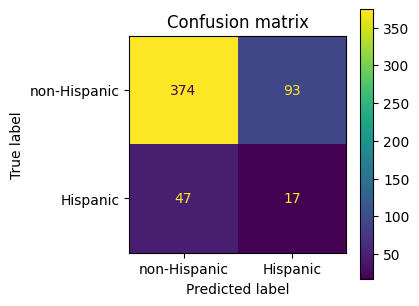

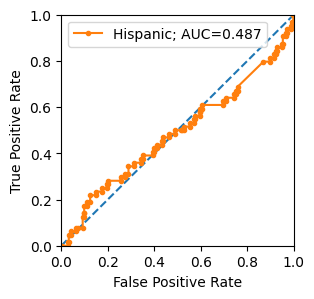

In [81]:
# train
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)
# test
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-%s'%ycol,ycol])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, ycol)

Mean accuracy: 0.7721
ROC AUC=0.565


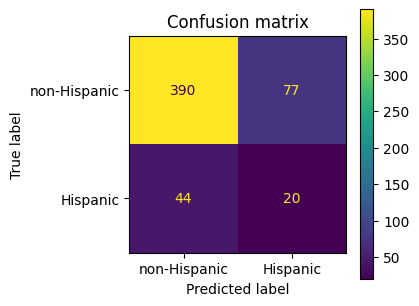

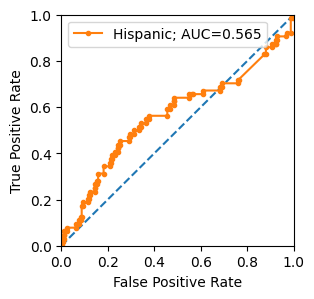

In [83]:
# Try SVM instead
clf = svm.SVC(kernel='rbf',probability=True, class_weight='balanced') # using radial-like kernal
clf.fit(X_train, y_train)
# test
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-%s'%ycol,ycol])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, ycol)

### Diabetes

When asked if they have diabetes, some people answered 'Prefer not to say'.
Handle that by excluding their data.

In [84]:
print('Q-personal_1: Have diabetes?')
print(data_df.drop_duplicates('ResponseId')['Q-personal_1'].value_counts())

Q-personal_1: Have diabetes?
No                   2307
Yes                   324
Prefer not to say       8
Name: Q-personal_1, dtype: int64


In [85]:
def get_diabetes_data_df(df, ycol='diabetes'):
    """
    Returns data df where there is a 1/0 binary for 'have diabetes?'
    And rows for respondents who 'Prefer not to say' are dropped
    """
    # drop rows with 'Prefer not to say'
    ddf = df[df['Q-personal_1'].isin(['No','Yes'])].copy()
    ddf[ycol] = ddf['Q-personal_1'].apply(lambda d: 1 if d=='Yes' else 0)
    return ddf

diabetes_data_df = get_diabetes_data_df(data_df)

In [86]:
print('%s rows of data for respondents with diabetes'%diabetes_data_df['diabetes'].sum())
print('%s respondents with diabetes'%diabetes_data_df.drop_duplicates('ResponseId')['diabetes'].sum())
diabetes_data_df[list(data_df.columns)[:8]+['Q-personal_1', 'diabetes']].head(3)

119165 rows of data for respondents with diabetes
324 respondents with diabetes


,ResponseId,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,Q-personal_1,diabetes
0,R_01vNIayewjIIKMF,2018-12-04,$7.98,1.0,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,FLASH_MEMORY,No,0
1,R_01vNIayewjIIKMF,2018-12-22,$13.99,1.0,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,HEADPHONES,No,0
2,R_01vNIayewjIIKMF,2018-12-24,$8.99,1.0,NJ,NaN,B078JZTFN3,NaN,No,0


In [87]:
# define the dataset
ycol = 'diabetes'
data = get_data_rel_orders_for_categories(diabetes_data_df, d_tcats, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
data.head()

(2631, 20) (2631,)


,YARN,PAPER_TOWEL,PAINT_BRUSH,SECURITY_CAMERA,FLAVORED_DRINK_CONCENTRATE,THERMOS,FABRIC,LITTER_BOX,REMOTE_CONTROL,WOUND_DRESSING,...,SEXUAL_STIMULATION_DEVICE,BADGE_HOLDER,VALVE,NECKLACE,VIDEO_GAME_ACCESSORIES,PERSONAL_FRAGRANCE,ENVELOPE,POWER_CORD,BODY_LUBRICANT,diabetes
ResponseId,,,,,,,,,,,,,,,,,,,,,
R_01vNIayewjIIKMF,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.087500,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.075000,0
R_037XK72IZBJyF69,0.010453,0.006969,0.0,0.000000,0.003484,0.000000,0.0,0.0,0.0,0.003484,...,0.000000,0.0,0.0,0.003484,0.000000,0.006969,0.003484,0.006969,0.000000,0
R_038ZU6kfQ5f89fH,0.000000,0.000000,0.0,0.037037,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.074074,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0
R_06RZP9pS7kONINr,0.000000,0.000000,0.0,0.000000,0.000000,0.007692,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.007692,0.000000,0.007692,0.007692,0.000000,1
R_06d9ULxrBmkwSTn,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


data partitioned into  80-20 train-test split
train size = 2104; test size = 527
254/2104 diabetes in train data
70/527 diabetes in test data
Mean accuracy: 0.6869
ROC AUC=0.565


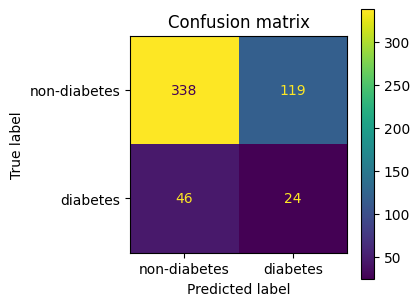

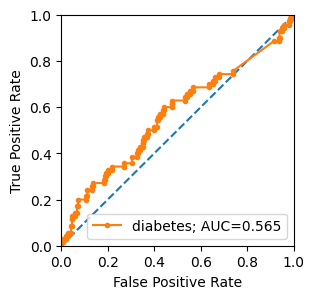

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('data partitioned into  80-20 train-test split')
print('train size = %s; test size = %s' % (len(X_train), len(X_test)))

print('%s/%s %s in train data\n%s/%s %s in test data' % (
    y_train.sum(),len(y_train), ycol, y_test.sum(),len(y_test), ycol))

# clf = svm.SVC(probability=True, class_weight='balanced') # using radial-like kernal
clf = svm.SVC(kernel='rbf',probability=True, class_weight='balanced') # using radial-like kernal
clf.fit(X_train, y_train)
# test
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-%s'%ycol,ycol])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, ycol)

### How to encode feature vectors: Relative orders vs one-hot encoding

Which works better?

Above uses relative orders. Here try one-hot encoding.

Doesn't work nearly as well for Asian! Works about as well for diabetes.

In [89]:
ycol = 'diabetes'
cats = d_tcats
# define the dataset
data = get_data_one_hot_encording_for_categories(diabetes_data_df, cats, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(2631, 20) (2631,)


Mean accuracy: 0.7078
ROC AUC=0.566


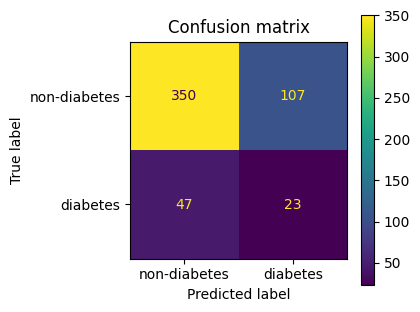

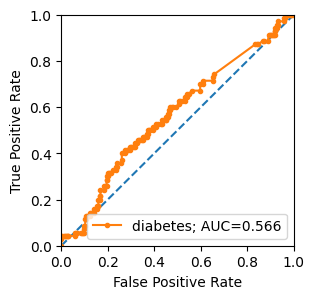

In [90]:
# Try SVM instead
clf = svm.SVC(kernel='rbf',probability=True, class_weight='balanced') # using radial-like kernal
clf.fit(X_train, y_train)
# test
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-%s'%ycol,ycol])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, ycol)

### Try another pipeline

- use larger set of categories to create feature vectors
- transform into n components with SVD

In [96]:
def get_lr_models(n_start, n_end, n_skip):
    models = dict()
    for n in range(n_start, n_end + n_skip, n_skip):
        models[str(n)] = Pipeline(steps=[
            ('svd', TruncatedSVD(n_components=n)), 
            ('m', LogisticRegression(class_weight='balanced'))
        ])
    return models

def get_svm_models(n_start, n_end, n_skip):
    models = dict()
    for n in range(n_start, n_end + n_skip, n_skip):
        models[str(n)] = Pipeline(steps=[
            ('svd', TruncatedSVD(n_components=n)), 
            ('m', svm.SVC(kernel='rbf', probability=True, class_weight='balanced'))
        ])
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    accuracy_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    auc_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return accuracy_scores, auc_scores

def test_svd_ml_pipeline(X, y, ylabel, n_start=10, n_end=100, n_skip=5, svm=False, ax=None, verbose=False):
    """
    Tests a pipeline using SVD with n components then model (SVM or logistic regression)
    Uses k-fold cross validation and evaluates mean AUC
    Tests with component n ranging from n_start to n_end
    Plots AUC results
    Returns best n and corresponding AUC score
    """
    model_type = 'SVM' if svm else 'logistic regression'
    print('%s: %s' % (ylabel, model_type))
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(6,3))
    # get the models to evaluate
    models = get_svm_models(n_start, n_end, n_skip) if svm else get_lr_models(n_start, n_end, n_skip)
    # track best n, best AUC
    best_n, best_AUC = 0, 0
    # evaluate the models and store results
    accuracy_scores_results, auc_scores_results, names = list(), list(), list()
    for name, model in models.items():
        accuracy_scores, auc_scores = evaluate_model(model, X, y)
        accuracy_scores_results.append(accuracy_scores)
        auc_scores_results.append(auc_scores)
        names.append(name)
        if mean(auc_scores) > best_AUC:
            if verbose:
                print('new best: n=%s' % name)
                print('>%s accuracy %.3f (%.3f)' % (name, mean(accuracy_scores), std(accuracy_scores)))
                print('>%s AUC %.3f (%.3f)' % (name, mean(auc_scores), std(auc_scores)))
            best_n = name
            best_AUC = mean(auc_scores)
    # plot model performance for comparison
    ax.set_title('[%s] SVD --> %s' % (ylabel, model_type))
    _ = ax.boxplot(auc_scores_results, labels=names, showmeans=True)
    ax.set_ylabel('AUC')
    ax.set_xlabel('components')
    plt.show()
    return best_n, best_AUC

In [92]:
print('using %s categories' % len(categories))

using 931 categories


In [93]:
ycol = 'Asian'
# define the dataset
data = get_data_rel_orders_for_categories(data_df, categories, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
print('using k-fold instead of train-test split')
print('%s/%s %s in data' % (y.sum(),len(y), ycol))

(2652, 931) (2652,)
using k-fold instead of train-test split
234/2652 Asian in data


Asian: logistic regression
new best: n=10
>10 accuracy 0.544 (0.036)
>10 AUC 0.582 (0.053)
new best: n=15
>15 accuracy 0.604 (0.026)
>15 AUC 0.640 (0.053)
new best: n=20
>20 accuracy 0.623 (0.024)
>20 AUC 0.648 (0.053)
new best: n=25
>25 accuracy 0.632 (0.026)
>25 AUC 0.653 (0.054)
new best: n=30
>30 accuracy 0.638 (0.026)
>30 AUC 0.656 (0.053)
new best: n=35
>35 accuracy 0.644 (0.026)
>35 AUC 0.659 (0.053)
new best: n=40
>40 accuracy 0.643 (0.028)
>40 AUC 0.661 (0.053)
new best: n=45
>45 accuracy 0.645 (0.025)
>45 AUC 0.662 (0.051)
new best: n=50
>50 accuracy 0.649 (0.027)
>50 AUC 0.662 (0.051)
new best: n=55
>55 accuracy 0.653 (0.024)
>55 AUC 0.664 (0.051)
new best: n=65
>65 accuracy 0.659 (0.026)
>65 AUC 0.664 (0.051)
new best: n=70
>70 accuracy 0.660 (0.026)
>70 AUC 0.665 (0.052)
new best: n=75
>75 accuracy 0.665 (0.028)
>75 AUC 0.666 (0.052)
new best: n=80
>80 accuracy 0.669 (0.025)
>80 AUC 0.668 (0.052)
new best: n=85
>85 accuracy 0.673 (0.027)
>85 AUC 0.669 (0.051)
new best: n=9

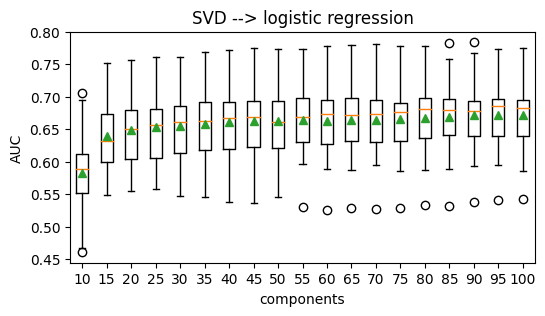

Asian
Logistic regression
Best: n=95; AUC=0.672


In [94]:
lr_best_n, lr_best_AUC = best_n, best_AUC = test_svd_ml_pipeline(X, y, 'Asian', verbose=True)
print(ycol)
print('Logistic regression')
print('Best: n=%s; AUC=%0.3f' % (lr_best_n, lr_best_AUC))

Asian: SVM


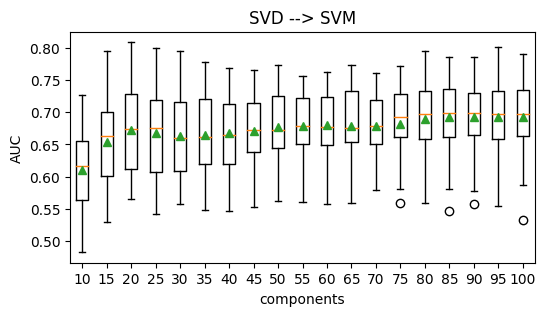

Asian
SVM regression
Best: n=100; AUC=0.693


In [95]:
svm_best_n, svm_best_AUC = best_n, best_AUC = test_svd_ml_pipeline(X, y, 'Asian', svm=True)
print(ycol)
print('SVM regression')
print('Best: n=%s; AUC=%0.3f' % (svm_best_n, svm_best_AUC))

### SVD pipeline for Black

In [97]:
ycol = 'Black'
# define the dataset
data = get_data_rel_orders_for_categories(data_df, categories, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
print('using k-fold instead of train-test split')
print('%s/%s %s in data' % (y.sum(),len(y), ycol))

(2652, 931) (2652,)
using k-fold instead of train-test split
234/2652 Black in data


Black: logistic regression
new best: n=10
>10 accuracy 0.573 (0.026)
>10 AUC 0.660 (0.054)
new best: n=15
>15 accuracy 0.648 (0.029)
>15 AUC 0.690 (0.052)
new best: n=20
>20 accuracy 0.652 (0.031)
>20 AUC 0.691 (0.055)
new best: n=25
>25 accuracy 0.679 (0.028)
>25 AUC 0.701 (0.055)
new best: n=30
>30 accuracy 0.686 (0.026)
>30 AUC 0.706 (0.055)
new best: n=35
>35 accuracy 0.697 (0.027)
>35 AUC 0.710 (0.056)
new best: n=40
>40 accuracy 0.702 (0.024)
>40 AUC 0.716 (0.058)
new best: n=45
>45 accuracy 0.707 (0.024)
>45 AUC 0.717 (0.057)
new best: n=50
>50 accuracy 0.710 (0.024)
>50 AUC 0.718 (0.057)
new best: n=55
>55 accuracy 0.711 (0.026)
>55 AUC 0.719 (0.055)
new best: n=65
>65 accuracy 0.716 (0.028)
>65 AUC 0.719 (0.056)
new best: n=70
>70 accuracy 0.720 (0.025)
>70 AUC 0.720 (0.055)
new best: n=75
>75 accuracy 0.721 (0.023)
>75 AUC 0.721 (0.055)
new best: n=80
>80 accuracy 0.724 (0.026)
>80 AUC 0.721 (0.056)
new best: n=85
>85 accuracy 0.724 (0.023)
>85 AUC 0.722 (0.056)
new best: n=9

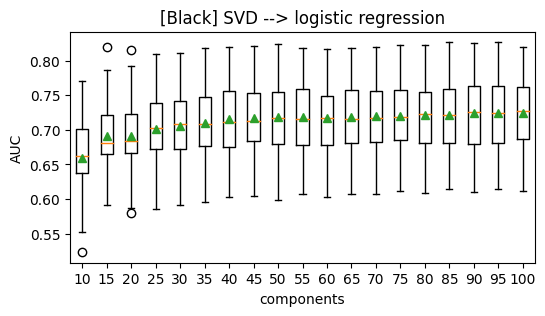

Black
Logistic regression
Best: n=100; AUC=0.725


In [98]:
lr_best_n, lr_best_AUC = best_n, best_AUC = test_svd_ml_pipeline(X, y, ycol, verbose=True)
print(ycol)
print('Logistic regression')
print('Best: n=%s; AUC=%0.3f' % (lr_best_n, lr_best_AUC))

Black: SVM


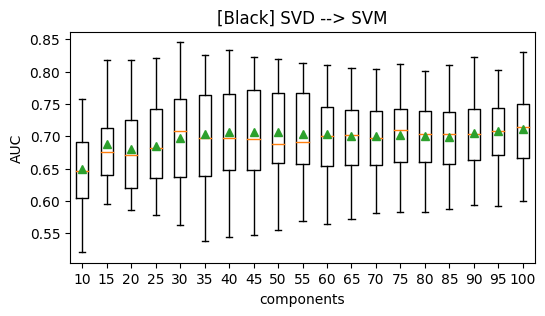

Black
SVM regression
Best: n=100; AUC=0.711


In [100]:
svm_best_n, svm_best_AUC = best_n, best_AUC = test_svd_ml_pipeline(X, y, ycol, svm=True)
print(ycol)
print('SVM regression')
print('Best: n=%s; AUC=%0.3f' % (svm_best_n, svm_best_AUC))

### For Hispanic

In [ ]:
ycol = 'Hispanic'
# define the dataset
data = get_data_rel_orders_for_categories(data_df, categories, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
print('using k-fold instead of train-test split')
print('%s/%s %s in data' % (y.sum(),len(y), ycol))

In [ ]:
lr_best_n, lr_best_AUC = best_n, best_AUC = test_svd_ml_pipeline(X, y, ycol, verbose=True)
print(ycol)
print('Logistic regression')
print('Best: n=%s; AUC=%0.3f' % (lr_best_n, lr_best_AUC))

In [ ]:
svm_best_n, svm_best_AUC = best_n, best_AUC = test_svd_ml_pipeline(X, y, 'Asian', svm=True)
print(ycol)
print('SVM regression')
print('Best: n=%s; AUC=%0.3f' % (svm_best_n, svm_best_AUC))

## Another ML Pipeline: SVD over products purchased

one-hot encodings for product purchase. i.e. a product code is a feature, where 1=product was purchsed at any time; otherwise 0.

Limit to products that were purchased by X% of the ppl.

In [89]:
n_products = data_df['ASIN/ISBN (Product Code)'].nunique()
print('%s total product codes in dataset' % n_products)

522613 total product codes in dataset


In [90]:
# Limit to products that were purchased by X% of the ppl.
product_purchasers_threshold_pct = 0.01
print('limit to products purchased from %s of purchasers'%product_purchasers_threshold_pct)
products_purchasers_threshold = data_df['ResponseId'].nunique() * product_purchasers_threshold_pct
print('%s total purchasers; %s purchaers = threshold'%(data_df['ResponseId'].nunique(), products_purchasers_threshold))

limit to products purchased from 0.01 of purchasers
2652 total purchasers; 26.52 purchaers = threshold


In [91]:
# Get the number of purchasers per product code
product_purchasers_count = data_df.groupby('ASIN/ISBN (Product Code)')['ResponseId'].nunique().sort_values(ascending=False)
product_purchasers_count.head()

ASIN/ISBN (Product Code)
B00IX1I3G6    666
B086KKT3RX    432
B07PCMWTSG    300
B004LLIKVU    270
B07FZ8S74R    203
Name: ResponseId, dtype: int64

Most products in our dataset were only purchased by one person

In [92]:
product_purchasers_count.describe()

count    522613.000000
mean          1.467288
std           2.379178
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         666.000000
Name: ResponseId, dtype: float64

In [93]:
feature_products = product_purchasers_count[product_purchasers_count > products_purchasers_threshold]
print('using %s products for feature vectors' % len(feature_products))

using 483 products for feature vectors


Most of the top products are gift cards and batteries

In [94]:
print(feature_products.head())
feature_products = feature_products.index
(data_df[data_df['ASIN/ISBN (Product Code)'].isin(feature_products[:10])]
 .drop_duplicates('ASIN/ISBN (Product Code)')[data_df.columns[:8]].head(10))

ASIN/ISBN (Product Code)
B00IX1I3G6    666
B086KKT3RX    432
B07PCMWTSG    300
B004LLIKVU    270
B07FZ8S74R    203
Name: ResponseId, dtype: int64


,ResponseId,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category
81,R_01vNIayewjIIKMF,2020-08-01,$25.00,1.0,NaN,Amazon.com Gift Card Balance Reload,B00IX1I3G6,GIFT_CARD
422,R_037XK72IZBJyF69,2020-04-30,$25.00,2.0,NaN,Amazon.com eGift Card,B07PCMWTSG,GIFT_CARD
1041,R_037XK72IZBJyF69,2021-10-09,$10.99,1.0,PA,Amazon Basics 36 Pack AAA High-Performance Alk...,B00LH3DMUO,BATTERY
1720,R_06RZP9pS7kONINr,2021-11-27,$19.99,1.0,NE,"Echo Dot (3rd Gen, 2018 release) - Smart speak...",B07FZ8S74R,DIGITAL_DEVICE_3
2494,R_08uYA7fb4unHGkF,2022-08-24,$7.00,1.0,NaN,Amazon Reload,B086KKT3RX,ABIS_GIFT_CARD
2600,R_0AjvU74YOfIrIpX,2020-11-27,$24.99,1.0,CA,"Amazon Smart Plug, works with Alexa – A Certif...",B01MZEEFNX,DIGITAL_DEVICE_3_ACCESSORY
2998,R_0BCm9hRP9iTI081,2019-12-16,$13.99,1.0,TX,Amazon Basics 48 Pack AA High-Performance Alka...,B00MNV8E0C,BATTERY
4239,R_0DoXqOQl0hxEeFH,2018-03-15,$32.82,1.0,NaN,Amazon.com eGift Card,B004LLIKVU,GIFT_CARD
6650,R_0UsrHmkw7rRzoeB,2018-11-01,$49.99,1.0,IL,Fire TV Stick 4K streaming device with Alexa V...,B079QHML21,DIGITAL_DEVICE_4
9596,R_0jFt3K3i4558lbj,2021-11-05,$100.00,1.0,NaN,Amazon eGift Card - Birthday Cupcakes,B07TMNGSN4,GIFT_CARD


In [95]:
def get_one_hot_product_vectors(df, product_code):
    return ((df[df['ASIN/ISBN (Product Code)']==product_code]
            .groupby(['ResponseId'])['Order Date'].count() > 0)
            .reindex(df['ResponseId'].unique())
            .fillna(0)
            .astype(int))

def get_one_hot_product_features_data(df, product_codes, Ycol):
    X_dict = {p: get_one_hot_product_vectors(df, p) for p in product_codes}
    X_dict['ResponseId'] = df['ResponseId'].unique()
    data = pd.DataFrame(X_dict).set_index('ResponseId')
    data[Ycol] = df.drop_duplicates('ResponseId').set_index('ResponseId')[Ycol].astype(int)
    return data

In [96]:
ycol = 'Black'
# define the dataset
data = get_one_hot_product_features_data(data_df, feature_products, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
print('using k-fold instead of train-test split')
print('%s/%s %s in data' % (y.sum(),len(y), ycol))

(2652, 483) (2652,)
using k-fold instead of train-test split
234/2652 Black in data


In [97]:
data.head(3)

,B00IX1I3G6,B086KKT3RX,B07PCMWTSG,B004LLIKVU,B07FZ8S74R,B079QHML21,B00LH3DMUO,B01MZEEFNX,B00MNV8E0C,B07TMNGSN4,...,B071CPR2V4,B0160HYB8S,B07G1VKCND,B005PLQIQ4,B00DS842HS,B006XISCNA,B073QMN75M,B07887CXXC,B07GW9TJ3G,Black
ResponseId,,,,,,,,,,,,,,,,,,,,,
R_01vNIayewjIIKMF,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
R_037XK72IZBJyF69,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
R_038ZU6kfQ5f89fH,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


>10 accuracy 0.453 (0.030)
>10 AUC 0.592 (0.063)
>14 accuracy 0.452 (0.029)
>14 AUC 0.581 (0.055)
>18 accuracy 0.458 (0.028)
>18 AUC 0.582 (0.058)
>22 accuracy 0.463 (0.028)
>22 AUC 0.568 (0.058)
>26 accuracy 0.477 (0.024)
>26 AUC 0.583 (0.053)
>30 accuracy 0.481 (0.030)
>30 AUC 0.579 (0.054)
>34 accuracy 0.485 (0.023)
>34 AUC 0.582 (0.055)
>38 accuracy 0.505 (0.030)
>38 AUC 0.586 (0.058)
>42 accuracy 0.507 (0.028)
>42 AUC 0.586 (0.055)
>46 accuracy 0.515 (0.027)
>46 AUC 0.588 (0.058)
>50 accuracy 0.520 (0.031)
>50 AUC 0.587 (0.061)
>54 accuracy 0.521 (0.029)
>54 AUC 0.584 (0.060)
>58 accuracy 0.527 (0.035)
>58 AUC 0.582 (0.064)
>62 accuracy 0.527 (0.030)
>62 AUC 0.583 (0.061)
>66 accuracy 0.538 (0.030)
>66 AUC 0.585 (0.064)
>70 accuracy 0.537 (0.035)
>70 AUC 0.578 (0.064)
>74 accuracy 0.537 (0.033)
>74 AUC 0.576 (0.054)
>78 accuracy 0.536 (0.029)
>78 AUC 0.578 (0.065)
>82 accuracy 0.537 (0.035)
>82 AUC 0.580 (0.063)
>86 accuracy 0.544 (0.033)
>86 AUC 0.567 (0.061)
>90 accuracy 0.545 (

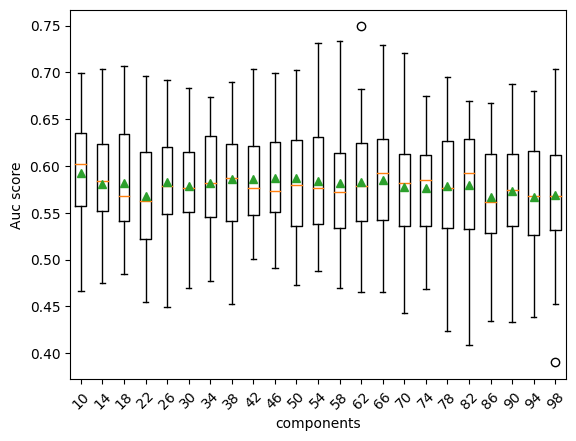

In [98]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(10, 100,4):
        steps = [('svd', TruncatedSVD(n_components=i)), ('m', LogisticRegression(class_weight='balanced'))]
        models[str(i)] = Pipeline(steps=steps)
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    accuracy_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    auc_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return accuracy_scores, auc_scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
accuracy_scores_results, auc_scores_results, names = list(), list(), list()
for name, model in models.items():
    accuracy_scores, auc_scores = evaluate_model(model, X, y)
    accuracy_scores_results.append(accuracy_scores)
    auc_scores_results.append(auc_scores)
    names.append(name)
    print('>%s accuracy %.3f (%.3f)' % (name, mean(accuracy_scores), std(accuracy_scores)))
    print('>%s AUC %.3f (%.3f)' % (name, mean(auc_scores), std(auc_scores)))
# plot model performance for comparison
plt.boxplot(auc_scores_results, labels=names, showmeans=True)
plt.xlabel('components')
plt.ylabel('Auc score')
plt.xticks(rotation=45)
plt.show()

## Inferring gender

Assumptions:

Gender differences will present themselves more in specific products vs categories.
- Results show this not so much the case?

Should be careful about:
- people sharing accounts or having larger households
- male/female binary vs others

So for this we initially limit data to:
- single_p_data_df: single person in household and using account
- people conforming to a male/female gender binary in response

In [101]:
data_df['Female'] = data_df['Q-demos-gender'].apply(lambda g: 1 if g=='Female' else 0)
data_df['Male'] = data_df['Q-demos-gender'].apply(lambda g: 1 if g=='Male' else 0)

Make data df for ppl who use their Amazon accounts for them alone
- Q-amazon-use-howmany = 1
- Q-amazon-use-hh-size = 1

How many people share the amazon account?
1 (just me!)    1874
2                575
3                124
4+                66
Name: Q-amazon-use-howmany, dtype: int64
Household size
1 (just me!)    604
2               802
3               535
4+              698
Name: Q-amazon-use-hh-size, dtype: int64


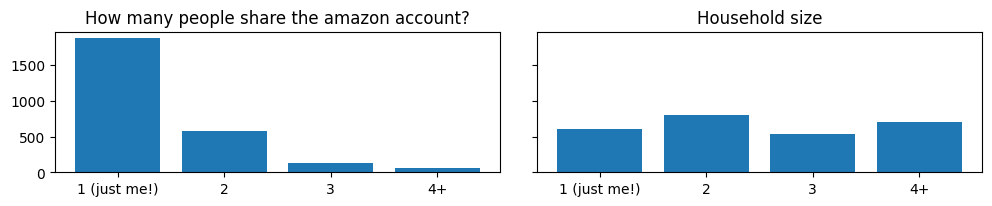

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(10,2), sharey=True)
plt.tight_layout()
print('How many people share the amazon account?')
print(data_df.drop_duplicates('ResponseId')['Q-amazon-use-howmany'].value_counts().sort_index())
ax = axes[0]
ax.set_title('How many people share the amazon account?')
ax.bar(
    data_df.drop_duplicates('ResponseId')['Q-amazon-use-howmany'].value_counts().sort_index().index,
    data_df.drop_duplicates('ResponseId')['Q-amazon-use-howmany'].value_counts().sort_index()
)
print('Household size')
print(data_df.drop_duplicates('ResponseId')['Q-amazon-use-hh-size'].value_counts().sort_index())
ax = axes[1]
ax.set_title('Household size')
_ = ax.bar(
    data_df.drop_duplicates('ResponseId')['Q-amazon-use-hh-size'].value_counts().sort_index().index,
    data_df.drop_duplicates('ResponseId')['Q-amazon-use-hh-size'].value_counts().sort_index()
)

Quick question:
Do Amazon accounts shared across more people end up making more purchases?

Answer: Yes

In [103]:
print('Median number of orders per account, by number of people sharing account')
orders_by_amazon_acct_size = (data_df.groupby(['Q-amazon-use-howmany', 'ResponseId'])['Order Date']
 .nunique().rename('order counts').reset_index()
 .groupby('Q-amazon-use-howmany')['order counts'].median())
orders_by_amazon_acct_size

Median number of orders per account, by number of people sharing account


Q-amazon-use-howmany
1 (just me!)     81.0
2               181.0
3               239.5
4+              239.0
Name: order counts, dtype: float64

Quick question:
Do Amazon accounts for larger households make more purchases?

In [104]:
print('Median number of orders per account, by household size')
orders_by_hh_size = (data_df.groupby(['Q-amazon-use-hh-size', 'ResponseId'])['Order Date']
 .nunique().rename('order counts').reset_index()
 .groupby('Q-amazon-use-hh-size')['order counts'].median())
orders_by_hh_size

Median number of orders per account, by household size


Q-amazon-use-hh-size
1 (just me!)     81.0
2               124.0
3                98.0
4+              126.5
Name: order counts, dtype: float64

Make dataframe restricted to purchases from people who do not share account and have household size of 1.

In [105]:
single_p_data_df = data_df[(
    (data_df['Q-amazon-use-hh-size']=='1 (just me!)') \
    & (data_df['Q-amazon-use-howmany']=='1 (just me!)'))]
print('limiting to data from single purchasers:')
print('%0.2f = %s/%s purchasers; %0.2f = %s/%s total purchases' % (
    single_p_data_df['ResponseId'].nunique()/data_df['ResponseId'].nunique(),
    single_p_data_df['ResponseId'].nunique(), data_df['ResponseId'].nunique(),
    len(single_p_data_df)/len(data_df), len(single_p_data_df), len(data_df)
))
single_p_data_df.head(3)

limiting to data from single purchasers:
0.21 = 551/2652 purchasers; 0.15 = 142175/922812 total purchases


,ResponseId,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category,q-demos-age,Q-demos-hispanic,...,Q-life-changes,unit price,total price,yyyy-mm,shipping state,Hispanic,Black,Asian,Female,Male
0,R_01vNIayewjIIKMF,2018-12-04,$7.98,1.0,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,FLASH_MEMORY,35 - 44 years,Yes,...,NaN,7.98,7.98,2018-12,NJ,1,True,False,0,1
1,R_01vNIayewjIIKMF,2018-12-22,$13.99,1.0,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,HEADPHONES,35 - 44 years,Yes,...,NaN,13.99,13.99,2018-12,NJ,1,True,False,0,1
2,R_01vNIayewjIIKMF,2018-12-24,$8.99,1.0,NJ,NaN,B078JZTFN3,NaN,35 - 44 years,Yes,...,NaN,8.99,8.99,2018-12,NJ,1,True,False,0,1


### Inspect gender

In [106]:
print('%s total respondents in all data' % data_df['ResponseId'].nunique())
(
    data_df.drop_duplicates('ResponseId')['Q-demos-gender'].value_counts().sort_index() \
    /data_df.drop_duplicates('ResponseId')['Q-demos-gender'].value_counts().sum()
).round(3)

2652 total respondents in all data


Female               0.528
Male                 0.448
Other                0.022
Prefer not to say    0.003
Name: Q-demos-gender, dtype: float64

In [107]:
print('%s total respondents in single purchasers data' % single_p_data_df['ResponseId'].nunique())
(
    single_p_data_df.drop_duplicates('ResponseId')['Q-demos-gender'].value_counts().sort_index() \
    /single_p_data_df.drop_duplicates('ResponseId')['Q-demos-gender'].value_counts().sum()
).round(3)

551 total respondents in single purchasers data


Female               0.512
Male                 0.459
Other                0.025
Prefer not to say    0.004
Name: Q-demos-gender, dtype: float64

Make gender dataframe where
- restricted to respondents who answered with male/female binary
- restricted to respondents who do not share their amazon account and have household size of 1
- Male=0/1
- Female=0/1

In [108]:
gender_data_df = single_p_data_df[(single_p_data_df['Female'] + single_p_data_df['Male']) > 0]
female_data_df = single_p_data_df[single_p_data_df['Female']==1]
male_data_df = single_p_data_df[single_p_data_df['Male']==1]

How do top categories differ by Male/Female?

In [109]:
female_rel_spend = pd.DataFrame({
    'Category': categories,
    'relative spend': [get_relative_spend(female_data_df, c) for c in categories]
}).sort_values('relative spend', ascending=False)
female_rel_spend.head(15)

,Category,relative spend
864,NOTEBOOK_COMPUTER,0.065580
203,CELLULAR_PHONE,0.050875
900,COMPUTER_PROCESSOR,0.050806
606,MATTRESS,0.039430
596,CAMERA_DIGITAL,0.038387
514,PERSONAL_COMPUTER,0.038041
678,TELEVISION,0.032612
478,VIDEO_PROJECTOR,0.031595
798,ABIS_BOOK,0.030354
197,AIR_CONDITIONER,0.025555


In [110]:
female_rel_pop = pd.DataFrame({
    'Category': categories,
    'relative orders': [get_relative_popularity(female_data_df, c) for c in categories]
}).sort_values('relative orders', ascending=False)
female_rel_pop.head(15)

,Category,relative orders
798,ABIS_BOOK,0.043798
567,PET_FOOD,0.024590
920,THERMOPLASTIC_FILAMENT,0.022186
306,BLANK_STORAGE_MEDIA,0.021277
426,SHIRT,0.015748
418,NUTRITIONAL_SUPPLEMENT,0.013468
15,GIFT_CARD,0.013041
836,PET_SUPPLIES,0.012773
781,HEALTH_PERSONAL_CARE,0.011752
222,KEYCAP,0.011608


Look at differences in relative spend and orders for female vs everyone else

In [111]:
print('For Female')
ppl_threshold = round(female_data_df['ResponseId'].nunique() * ppl_threshold_portion)
print('unique purchasers thershold: %s (%s)' % (ppl_threshold, ppl_threshold_portion))

female_cats_ppl = female_data_df.groupby('Category')['ResponseId'].nunique().sort_values(ascending=False)
print('%s unique categories'% len(female_cats_ppl))
female_cats_ppl = female_cats_ppl[female_cats_ppl > ppl_threshold]
print('%s categories above threshold' % len(female_cats_ppl))
female_cats = female_cats_ppl.index
female_cats_ppl.head()

For Female
unique purchasers thershold: 28 (0.1)
1518 unique categories
361 categories above threshold


Category
ABIS_BOOK               258
HEALTH_PERSONAL_CARE    198
CELLULAR_PHONE_CASE     185
SHIRT                   179
BEAUTY                  178
Name: ResponseId, dtype: int64

In [112]:
female_pop_diff = (
    (abs(female_rel_pop.set_index('Category')['relative orders'].loc[female_cats] \
      - cat_rel_pop.set_index('Category')['relative orders'].loc[female_cats]) \
     /cat_rel_pop.set_index('Category')['relative orders'].loc[female_cats])
    .rename('difference in rel popularity')
)
female_pop_diff = female_pop_diff.sort_values(ascending=False)
female_spend_diff = (
    (abs(female_rel_spend.set_index('Category')['relative spend'].loc[female_cats] \
      - cat_rel_spend.set_index('Category')['relative spend'].loc[female_cats]) \
     /cat_rel_spend.set_index('Category')['relative spend'].loc[female_cats])
    .rename('difference in rel spend')
)
female_spend_diff = female_spend_diff.sort_values(ascending=False)
female_spend_diff.head(10)
# female_pop_diff.head(20)

Category
ANIMAL_NUTRITIONAL_SUPPLEMENT    0.938085
SPRAY_BOTTLE                     0.906698
NIGHTGOWN_NIGHTSHIRT             0.820900
TRAY                             0.811541
LEGUME                           0.801921
INKJET_PRINTER_INK               0.799974
SKIRT                            0.774409
MEAT                             0.755502
CLOTHES_RACK                     0.742214
BODY_STRAP                       0.741938
Name: difference in rel spend, dtype: float64

In [113]:
female_pop_diff.head(10)

Category
LEGUME                 1.022098
SKIRT                  0.953125
TUNIC                  0.911583
WALL_ART               0.792000
SKIN_TREATMENT_MASK    0.777630
MICROPHONE             0.725628
ICE_CUBE_TRAY          0.718750
TABLE                  0.708696
PLANTER                0.706729
INKJET_PRINTER_INK     0.667513
Name: difference in rel popularity, dtype: float64

In [114]:
# defining top categories by spend
female_tcats = female_pop_diff.head(tcats_count).index.to_list()

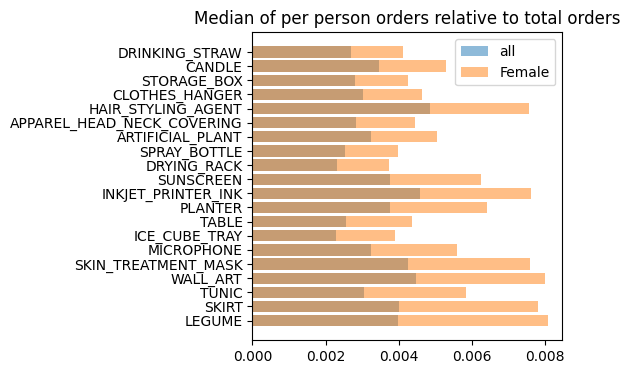

In [115]:
fig, ax = plt.subplots(1,1, figsize=(4, 4*tcats_count/20))
ax.set_title('Median of per person orders relative to total orders')
ax.barh(female_tcats, cat_rel_pop.set_index('Category').loc[female_tcats]['relative orders'], alpha=0.5, label='all')
ax.barh(female_tcats, female_rel_pop.set_index('Category').loc[female_tcats]['relative orders'], alpha=0.5, label='Female')
_ = ax.legend()

Observations:
- Females spend less on proteign supplement powder
- Females spend less on computer related items

### Gender models

By category

In [116]:
ycol = 'Female'
cats = female_tcats
# define the dataset
data = get_data_rel_orders_for_categories(gender_data_df, cats, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('data partitioned into  80-20 train-test split')
print('train size = %s; test size = %s' % (len(X_train), len(X_test)))
print('%s/%s %s in train data\n%s/%s %s in test data' % (y_train.sum(),len(y_train), ycol, y_test.sum(),len(y_test), ycol))

(535, 20) (535,)
data partitioned into  80-20 train-test split
train size = 428; test size = 107
231/428 Female in train data
51/107 Female in test data


Mean accuracy: 0.6449
ROC AUC=0.715


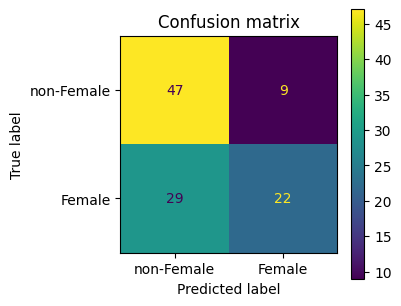

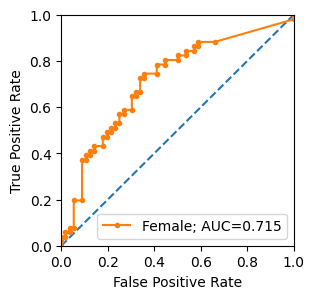

In [117]:
# Simple logistic regression
# train
clf = LogisticRegression(class_weight='balanced')
clf.fit(X_train, y_train)
# test
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-%s'%ycol,ycol])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, ycol)

Mean accuracy: 0.6449
ROC AUC=0.698


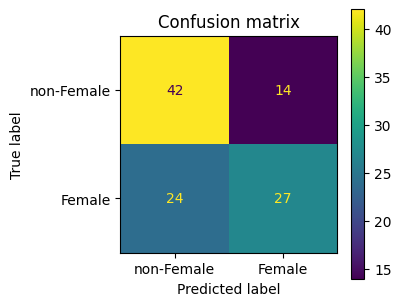

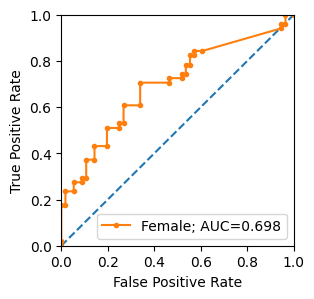

In [118]:
clf = svm.SVC(kernel='rbf',probability=True, class_weight='balanced') # using radial-like kernal
clf.fit(X_train, y_train)
# test
fig,ax = plt.subplots(1,1,figsize=(3.5,3.5))
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax, display_labels=['non-%s'%ycol,ycol])
_ = plt.title('Confusion matrix')
print('Mean accuracy: %0.4f' % clf.score(X_test, y_test))
auc = get_auc_plot_roc(clf, X_test, y_test.values, ycol)

Use pipeline with SVD:
- use larger set of categories to create feature vectors
- transform into n components with SVD
- apply model

In [119]:
print('using %s categories' % len(categories))

using 931 categories


In [120]:
# define the dataset
print(ycol)
data = get_data_rel_orders_for_categories(gender_data_df, categories, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
print('using k-fold instead of train-test split')
print('%s/%s %s in data' % (y.sum(),len(y), ycol))

Female
(535, 931) (535,)
using k-fold instead of train-test split
282/535 Female in data


Female: logistic regression


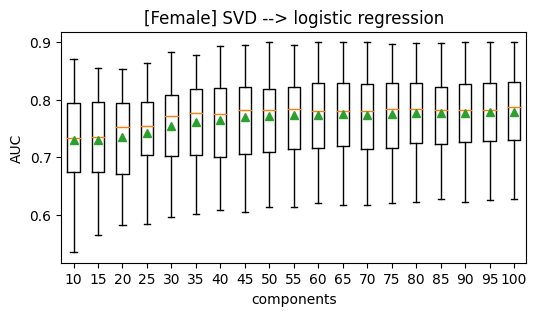

Female
Logistic regression
Best: n=100; AUC=0.779


In [122]:
lr_best_n, lr_best_AUC = test_svd_ml_pipeline(X, y, ycol, svm=False)
print(ycol)
print('Logistic regression')
print('Best: n=%s; AUC=%0.3f' % (lr_best_n, lr_best_AUC))

Female: SVM


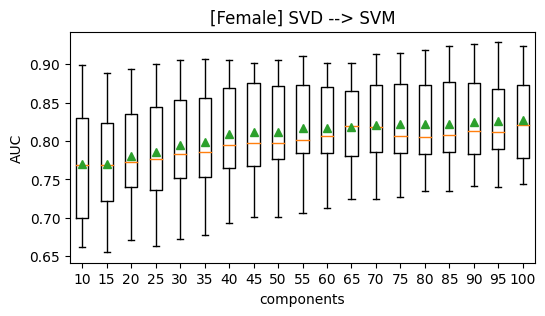

Female
SVM regression
Best: n=100; AUC=0.827


In [123]:
svm_best_n, svm_best_AUC = test_svd_ml_pipeline(X, y, ycol, svm=True)
print(ycol)
print('SVM regression')
print('Best: n=%s; AUC=%0.3f' % (svm_best_n, svm_best_AUC))

#### Modeling for product vectors

one-hot encodings for product purchase. i.e. a product code is a feature, where 1=product was purchsed at any time; otherwise 0.

Limit to products that were purchased by X% of the ppl.

In [274]:
n_products_g = gender_data_df['ASIN/ISBN (Product Code)'].nunique()
print('%s total product codes in gender dataset' % n_products_g)

# Limit to products that were purchased by X% of the ppl.
product_purchasers_threshold_pct = 0.01
print('limit to products purchased from %s of purchasers'%product_purchasers_threshold_pct)
products_purchasers_threshold_g = round(gender_data_df['ResponseId'].nunique() * product_purchasers_threshold_pct)
print('%s total purchasers; %s purchasers = threshold'%(gender_data_df['ResponseId'].nunique(), products_purchasers_threshold_g))

97483 total product codes in gender dataset
limit to products purchased from 0.01 of purchasers
535 total purchasers; 5 purchaers = threshold


In [283]:
# Get the number of purchasers per product code
product_purchasers_count_g = gender_data_df.groupby('ASIN/ISBN (Product Code)')['ResponseId'].nunique().sort_values(ascending=False)
print('purchasers by product: distribution')
print(product_purchasers_count_g.describe())
gender_feature_products = product_purchasers_count_g[product_purchasers_count_g > products_purchasers_threshold_g]
print('\nusing %s products for gender feature vectors' % len(gender_feature_products))
gender_feature_products = gender_feature_products.index
(gender_data_df[gender_data_df['ASIN/ISBN (Product Code)'].isin(gender_feature_products[:8])]
 .drop_duplicates('ASIN/ISBN (Product Code)')[gender_data_df.columns[:8]].head(10))

purchasers by product: distribution
count    97483.000000
mean         1.165588
std          0.894424
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        130.000000
Name: ResponseId, dtype: float64

using 463 products for gender feature vectors


,ResponseId,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,ASIN/ISBN (Product Code),Category
81,R_01vNIayewjIIKMF,2020-08-01,$25.00,1.0,NaN,Amazon.com Gift Card Balance Reload,B00IX1I3G6,GIFT_CARD
2494,R_08uYA7fb4unHGkF,2022-08-24,$7.00,1.0,NaN,Amazon Reload,B086KKT3RX,ABIS_GIFT_CARD
2600,R_0AjvU74YOfIrIpX,2020-11-27,$24.99,1.0,CA,"Amazon Smart Plug, works with Alexa – A Certif...",B01MZEEFNX,DIGITAL_DEVICE_3_ACCESSORY
9596,R_0jFt3K3i4558lbj,2021-11-05,$100.00,1.0,NaN,Amazon eGift Card - Birthday Cupcakes,B07TMNGSN4,GIFT_CARD
10772,R_10GfwNctrOL9e2t,2022-09-18,$7.99,1.0,NaN,Apple Lightning to 3.5 mm Headphone Jack Adapter,B01LXJFMGF,ELECTRONIC_ADAPTER
27092,R_1C9JNFshblsSjyF,2021-04-26,$10.00,1.0,NaN,Amazon.com eGift Card,B07PCMWTSG,GIFT_CARD
37002,R_1Duw20LaOXMnKSN,2019-12-02,$100.00,1.0,NaN,Amazon.com eGift Card,B004LLIKVU,GIFT_CARD
37003,R_1Duw20LaOXMnKSN,2019-12-02,$22.00,1.0,SC,"Echo Dot (3rd Gen, 2018 release) - Smart speak...",B07FZ8S74R,DIGITAL_DEVICE_3


In [284]:
# define the dataset
print(ycol)
data = get_one_hot_product_features_data(gender_data_df, gender_feature_products, ycol)
X, y = data.drop(ycol,axis=1), data[ycol]
print(X.shape, y.shape)
print('using k-fold instead of train-test split')
print('%s/%s %s in data' % (y.sum(),len(y), ycol))

Female
(535, 463) (535,)
using k-fold instead of train-test split
282/535 Female in data


>10 accuracy 0.604 (0.054)
>10 AUC 0.655 (0.055)
>14 accuracy 0.606 (0.055)
>14 AUC 0.658 (0.054)
>18 accuracy 0.594 (0.050)
>18 AUC 0.654 (0.065)
>22 accuracy 0.596 (0.059)
>22 AUC 0.657 (0.057)
>26 accuracy 0.617 (0.057)
>26 AUC 0.675 (0.064)
>30 accuracy 0.617 (0.063)
>30 AUC 0.680 (0.068)
>34 accuracy 0.619 (0.052)
>34 AUC 0.679 (0.061)
>38 accuracy 0.618 (0.062)
>38 AUC 0.687 (0.065)
>42 accuracy 0.619 (0.064)
>42 AUC 0.691 (0.064)
>46 accuracy 0.623 (0.061)
>46 AUC 0.690 (0.066)
>50 accuracy 0.613 (0.062)
>50 AUC 0.690 (0.067)
>54 accuracy 0.607 (0.063)
>54 AUC 0.682 (0.067)
>58 accuracy 0.619 (0.064)
>58 AUC 0.686 (0.072)
>62 accuracy 0.611 (0.069)
>62 AUC 0.688 (0.066)
>66 accuracy 0.625 (0.072)
>66 AUC 0.691 (0.069)
>70 accuracy 0.620 (0.072)
>70 AUC 0.692 (0.069)
>74 accuracy 0.625 (0.074)
>74 AUC 0.692 (0.079)
>78 accuracy 0.629 (0.071)
>78 AUC 0.690 (0.076)
>82 accuracy 0.631 (0.072)
>82 AUC 0.695 (0.080)
>86 accuracy 0.630 (0.073)
>86 AUC 0.701 (0.084)
>90 accuracy 0.622 (

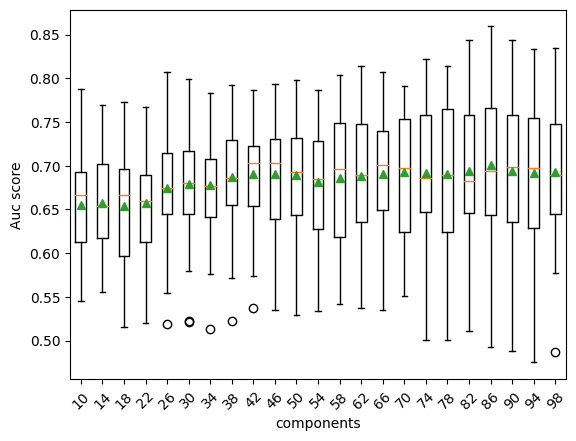

In [285]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(10, 100,4):
        steps = [('svd', TruncatedSVD(n_components=i)), ('m', LogisticRegression(class_weight='balanced'))]
        models[str(i)] = Pipeline(steps=steps)
    return models

# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    accuracy_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    auc_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return accuracy_scores, auc_scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
accuracy_scores_results, auc_scores_results, names = list(), list(), list()
for name, model in models.items():
    accuracy_scores, auc_scores = evaluate_model(model, X, y)
    accuracy_scores_results.append(accuracy_scores)
    auc_scores_results.append(auc_scores)
    names.append(name)
    print('>%s accuracy %.3f (%.3f)' % (name, mean(accuracy_scores), std(accuracy_scores)))
    print('>%s AUC %.3f (%.3f)' % (name, mean(auc_scores), std(auc_scores)))
# plot model performance for comparison
plt.boxplot(auc_scores_results, labels=names, showmeans=True)
plt.xlabel('components')
plt.ylabel('Auc score')
plt.xticks(rotation=45)
plt.show()

### Outcomes

Modeling with category codes works better than product codes (with current dataset size)

## TODO / to try

- encode vectors using tf-idf

## Notes

Below is an illustrative example of why we do not look at absolute values and instead look at per person values

In [61]:
# How do the top purchased items differ by categories?

df = data_df[data_df['Q-personal_2']=='Yes']
print('top categories for people with diabetes:')
print(df['Category'].value_counts().head(12))

top categories for people with diabetes:
ABIS_BOOK                 581
PET_FOOD                  574
NUTRITIONAL_SUPPLEMENT    318
HEALTH_PERSONAL_CARE      302
MEDICATION                296
GIFT_CARD                 265
VITAMIN                   221
ELECTRONIC_CABLE          208
GROCERY                   195
HERBAL_SUPPLEMENT         183
THERMOPLASTIC_FILAMENT    178
SHIRT                     177
Name: Category, dtype: int64


Observations:
- HEALTH_PERSONAL_CARE and MEDICATION in top 5 categories for ppl with diabetes, this is not the case for general population
- VITAMIN and HERBAL_SUPPLEMENT in top 10 categories for ppl with diabetes; not the case for general population

- THERMOPLASTIC_FILAMENT in top 12 for ppl with diabetes -- what is that?

In [67]:
# What is a thermoplastic filament?
# this is a good reason to normalize by person! There might be a person who loves 3D printing
print(df[df['Category']=='THERMOPLASTIC_FILAMENT']['Title'].value_counts().head())
df[df['Category']=='THERMOPLASTIC_FILAMENT'][list(df.columns[:5])].head()

Silk Copper PLA 3D Printer Filament 1.75 mm 1KG 2.2LBS Spool 3D Printing Material Shine Silky Shiny Metallic Metal Red Purple Copper PLA Filament CC3D                                                      11
PLA Max PLA + Grass Green Filament 1.75 mm 3D Printer PLA Filament 1KG 2.2LBS Spool 3D Printing Material Stronger Than Normal PLA Pro Plus Filament CC3D                                                     7
Polymaker Matte PLA Filament 1.75mm Pastel Peanut, 1.75 PLA 3D Printer Filament 1kg - PolyTerra 1.75 PLA Filament Matte Peanut Tan 3D Printing Filament (1 Tree Planted)                                     7
eSUN PLA PRO (PLA+) 3D Printer Filament, Dimensional Accuracy +/- 0.03 mm, 1kg Spool, 1.75mm, Yellow                                                                                                         5
OVERTURE PLA Plus (PLA+) Filament 1.75mm, PLA Professional Toughness Enhanced PLA Roll, Cardboard Spool, Cardboard Spool, Premium PLA 1kg(2.2lbs), Accuracy 99% Probability 

,ResponseId,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State
437002,R_2cozRynbM2kFaF6,11/15/19,$12.47,1,TX
512562,R_2wzatCV9Z18xLF2,06/22/18,$17.99,1,GA
512571,R_2wzatCV9Z18xLF2,07/14/18,$20.99,1,GA
512590,R_2wzatCV9Z18xLF2,08/01/18,$9.99,1,GA
512592,R_2wzatCV9Z18xLF2,08/11/18,$14.99,1,GA
